# Surge Pricing in the Airbnb Market: Evidence from the 2017 Boston Marathon
### By: Eli Easton


# Project 1

# 1. Introduction

In April 2017, the Boston Marathon drew tens of thousands of people to Boston, Massachusetts (Boston Athletic Association, 2017). How, then, did this influx of visitors impact the Boston Airbnb market? Further, was there variation in 'marathon pricing behaviour' by host type? Also, do certain Airbnbs disproportionately benefit from the increased tourism brought about by the marathon? 

Much research has been done on how ride sharing prices respond to major events (Jiao, 2018; Cachon et al., 2017). There also exists literature on how events impact hotel performance (Piga & Melis, 2021). With regards to Airbnb, there exists a swath of literature focusing how Airbnb impacts the housing market (Segu et al., 2020; Benítez-Aurioles & Tussyadiah, 2021; Liang et al., 2022; Brunstein et al., 2025). There also exists extensive literature on how Airbnb affects local tourism markets (Jiménez et al., 2022). Alongside this, some researchers have produced literature on Airbnb's dynamic pricing behaviour (Leoni & Nilsson, 2021; Lorde et al., 2019). Notably, however, there exists literature that examines claims of Airbnb promoting inclusive tourism, in which Airbnb potentially allows households to benefit from tourist activity when they otherwise would not have absent Airbnb (Kadi et al., 2022). 

I first find that Airbnb listing prices spiked the weekend before and the day of the Boston Marathon. From this, I hypothesize that the Boston Marathon increased local demand only for Airbnbs near the Boston Marathon route, and that Airbnbs farther from the route are not impacted by this hypothesized demand surge brought about by the marathon. This hypothesis is crucial because if it holds I can assign listings into treatment and control groups. I find that it indeed holds after comparing price distributions for listings 'close', 'mid-range', and 'far' from the marathon finish line. 

Then, I create maps and conduct difference-in-differences regression analyses akin to Angrist & Pischke (2015). I test my regression assumptions by conducting a parallel trends assessment as described by Fredriksson & Oliveira (2019). I also perform placebo tests for both regression analyses as outlined by Cunningham (2021). I ultimately find that there was a ‘Boston Marathon effect’ on Airbnb listing prices for listings 'close' to the finish line, and that Superhosts vary in their 'marathon pricing strategy' compared to non Superhosts.

Lastly, I perform web scraping to assess if other events may be driving tourism and thus the marathon price effect. I find that this is likely not the case. After, I run machine learning models to assess which kinds of Airbnbs captured the highest prices on the day of the Boston Marathon. I find that entire homes or apartments with more than 1.25 bathrooms and which are managed by hosts with more than 10 properties yielded the highest price. This ultimately suggests that career hosts, or landlords with multiple Airbnb properties, benefited most from marathon tourism in terms of the absolute price level. 

# 2. Data Cleaning & Loading

I begin with the Boston Airbnb Calendar dataset, which contains 1.05 million observations of Airbnb listing-dates in Boston from September 2016 to September 2017. This dataset allows me to observe the change in a property's listing price over time. To obtain more detailed information on Airbnb properties, I then merge it with the Boston Airbnb Listings dataset, which contains data on the characteristics of these 3586 Airbnb properties. Lastly, it is understood that the level of crime in a neighbourhood impacts property value (Cheung & Yiu, 2023). Therefore, I also merge the Crimes in Boston dataset to control for daily fluctuations in crime.

My main outcome variable is daily Airbnb listing prices. My main controls are room, property, and bed type, the number of bathrooms, bedrooms, and beds. Intuitively, these variables influence price. I also consider controlling for review score rating and a Superhost dummy. Akin to Lawani et al. (2019) review scores can serve as a proxy for property quality, which influences price. Also, Superhost status is another indicator of quality that may impact pricing (Ert & Fleischer, 2019).

In [908]:
#Import libraries
import matplotlib
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as dates
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import qeds
import seaborn as sns
import statsmodels.api as sm
import stargazer as Stargazer
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML
import geopandas as gpd
import geodatasets
from shapely.geometry import Point

#Change font to Garamond
plt.rcParams["font.family"] = "Garamond"

#Load calendar dataset
calendar = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                       "ECO225Project\\Data\\Boston\\calendar.csv")

#Clean "calendar"

#Rename "listing_id" column to "id"
calendar.rename(columns={"listing_id": "id"}, inplace=True)

#Clean price column to remove $ and zeroes, convert to float
calendar["price"] = calendar["price"].astype(str).str.replace("$", 
                    "").str.replace(".00", "").str.replace(",", "") \
                    .astype(float)

#Create "year_month" column from the "date" column in "df_calendar" dataset
#Convert "date" column to datetime
#Documentation: 
#https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
calendar["date"] = pd.to_datetime(calendar["date"])

#Create "year_month" column
calendar["year_month"] = calendar["date"].dt.to_period("M")

#Set calendar index
calendar.set_index("id")

#Load listings dataset
listings = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                    "ECO225Project\\Data\\Boston\\listings.csv").set_index("id")

#Clean "listings"

listings.drop(columns=["listing_url", "scrape_id", "last_scraped", "name", 
                       "summary", "space", "description", 
                       "experiences_offered", "neighborhood_overview", 
                       "notes", "transit", "access", "interaction", 
                       "house_rules", "thumbnail_url", "medium_url", 
                       "picture_url", "xl_picture_url", 
                       "host_url", "host_name", "host_since", "host_location", 
                       "host_about", "host_response_time", 
                       "host_response_rate", "host_acceptance_rate", 
                       "host_thumbnail_url", "host_picture_url", 
                       "host_neighbourhood", 
                       "host_verifications", "host_has_profile_pic", 
                       "host_identity_verified", "neighbourhood", 
                       "neighbourhood_group_cleansed", "market", 
                       "smart_location", "country_code", "country", 
                       "is_location_exact", "weekly_price", "monthly_price", 
                       "calendar_updated", "has_availability", 
                       "availability_30", "availability_60", "availability_90", 
                       "availability_365", "calendar_last_scraped", 
                       "first_review", "last_review", 
                       "review_scores_accuracy", "review_scores_cleanliness", 
                       "review_scores_checkin", 
                       "review_scores_communication", "review_scores_location", 
                       "review_scores_value", "requires_license", 
                       "license", "jurisdiction_names", "instant_bookable", 
                       "cancellation_policy", "require_guest_profile_picture", 
                       "require_guest_phone_verification", 
                       "calculated_host_listings_count", "reviews_per_month", 
                       "state", "minimum_nights", "maximum_nights", 
                       "guests_included", "extra_people", "square_feet", 
                       "security_deposit", "price", "number_of_reviews"], 
                       inplace=True)

#Create dummy variables
#Superhost
listings["Superhost"] = listings["host_is_superhost"].map({"t": 1, "f": 0})
listings.drop(columns=["host_is_superhost"], inplace=True)

#Room type
dummies = pd.get_dummies(listings["room_type"], drop_first=False)
dummies = dummies.astype(int)
listings = pd.concat([listings, dummies], axis=1)

#Property type
dummies = pd.get_dummies(listings["property_type"], drop_first=False)
dummies = dummies.astype(int)
listings = pd.concat([listings, dummies], axis=1)

#Bed type
dummies = pd.get_dummies(listings["bed_type"], drop_first=False)
dummies = dummies.astype(int)
listings = pd.concat([listings, dummies], axis=1)

#Neighbourhood
dummies = pd.get_dummies(listings["neighbourhood_cleansed"], drop_first=False)
dummies = dummies.astype(int)
listings = pd.concat([listings, dummies], axis=1)

#Merge datasets on id
cal_lis = pd.merge(calendar, listings, on="id", how="outer")

#Load crime dataset
crime = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                    "ECO225Project\\Data\\crime.csv", encoding="latin1", 
                    low_memory=False)

#Clean "crime"

crime.drop(columns=["INCIDENT_NUMBER", "OFFENSE_CODE", 
                    "OFFENSE_DESCRIPTION", "DISTRICT", "REPORTING_AREA", 
                    "SHOOTING", "DAY_OF_WEEK", "HOUR", "UCR_PART", "Lat", 
                    "Long", "STREET"], inplace=True)

#Convert "OCCURRED_ON_DATE" column to datetime
crime["OCCURRED_ON_DATE"] = pd.to_datetime(crime["OCCURRED_ON_DATE"])

#Create "year_month_crime" column from the "OCCURRED_ON_DATE" column
crime["year_month_crime"] = crime["OCCURRED_ON_DATE"].dt.to_period("M")

#Filter dataset to include only data from September 2016 to September 2017
crime = crime[(crime["year_month_crime"] >= "2016-09") & 
              (crime["year_month_crime"] <= "2017-09")]

#Stack "cal_lis" and "crime" datasets
CalLisCrime = pd.concat([cal_lis, crime], axis = 0)

#Create a "crime_count" column in "CalLisCrime" dataset that gives the number of
#crimes that occurred on each date
crime_grouped = crime.groupby(
    "OCCURRED_ON_DATE").size().reset_index(name="crime_count")
CalLisCrime = pd.merge(CalLisCrime, crime_grouped, left_on="date", 
                       right_on="OCCURRED_ON_DATE", how="left")

# 3. Summary Statistics

## 3.1. Summary Statistics of Outcome and Key Control Variables

In [909]:
#Generate Summary Statistics of price, bathrooms, bedrooms, beds, and 
#review scores

#Drop duplicate listings 
listings_temp1 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

summary_stats1 = listings_temp1[["bathrooms", "bedrooms", "beds", 
                                 "review_scores_rating", "Superhost"]] \
                                .describe().round(3)

#Rename rows
summary_stats1.index = ["Total Observations", "Mean", "Standard Deviation", 
                        "Minimum", "25th Percentile", 
                        "Median (50th Percentile)", "75th Percentile", 
                        "Maximum"]

#Rename columns
summary_stats1.rename(columns={"price": "Price", "bathrooms": "Bathrooms", 
                               "bedrooms": "Bedrooms", "beds": "Beds", 
                               "review_scores_rating": 
                               "Review Scores Rating"}, inplace=True)

#Create title
summary_stats1.style.set_caption("Table 1: Summary Statistics of \
            Key Regressors: Boston Airbnb Properties").format("{:.3f}")


,Bathrooms,Bedrooms,Beds,Review Scores Rating,Superhost
Total Observations,3571.000,3575.000,3576.000,2772.000,3585.000
Mean,1.222,1.256,1.609,91.917,0.114
Standard Deviation,0.501,0.753,1.012,9.532,0.317
Minimum,0.000,0.000,0.000,20.000,0.000
25th Percentile,1.000,1.000,1.000,89.000,0.000
Median (50th Percentile),1.000,1.000,1.000,94.000,0.000
75th Percentile,1.000,2.000,2.000,98.250,0.000
Maximum,6.000,5.000,16.000,100.000,1.000


The average number of bathrooms, bedrooms, and beds indicates that most properties are small. However, the presence of large outliers, and a median lower than the mean, indicates a right skew in the distributions of these variables. Further, it is likely that these variables are correlated with listing price, and thus are confounders which must be controlled in my regression.

Additionally, Airbnb review scores are high, with an average of 91.9 and a median of 94, suggesting a left skew in the distribution. While review scores may be a proxy for quality and correlate with price, one can also imagine leaving a positive review for a quality listing that had a lower price. 

Also, superhosts are somewhat rare, with only 11.4% of hosts meeting the criteria. Thus, non superhost properties primarily drive price trends, making this variable a reasonable control.


## 3.2. Summary Statistics of Daily Listing Price

In [910]:
#Generate summary statistics of price over time

#Group CalLisCrime by "year_month" and create summary statistics of price
#for each month
summary_stats2 = CalLisCrime.groupby("date")["price"].describe() \
                            .round(2)

#Filter to include only days from April 10, 2017 to April 18, 2017
summary_stats2 = summary_stats2[(summary_stats2.index >= "2017-04-10") & 
                                (summary_stats2.index <= "2017-04-18")]

#Remove the "00:00:00" from the date index
summary_stats2.index = summary_stats2.index.strftime("%Y-%m-%d")

#Rename columns
summary_stats2.rename(columns={"count": "Count", "mean": "Mean", "std": 
                               "Standard Deviation", "min": "Minimum", 
                               "25%": "25th Percentile", "50%": 
                               "Median (50th Percentile)", "75%": 
                               "75th Percentile", "max": "Maximum"},
                               inplace=True)

#Rename index column
summary_stats2.rename_axis(index="date", inplace=True)

#Create title and round numbers to 2 decimal places
summary_stats2.style.set_caption("Table 2: Summary Statistics of Airbnb \
                                Listing Price over Time - Boston, MA: April 10th, 2017 to \
                                April 18th, 2017").format("{:.2f}")

,Count,Mean,Standard Deviation,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum
date,,,,,,,,
2017-04-10,1736.00,186.63,165.99,20.00,80.00,150.00,249.00,4000.00
2017-04-11,1730.00,187.68,170.96,20.00,80.00,150.00,249.00,4000.00
2017-04-12,1727.00,193.12,179.33,20.00,80.00,150.00,250.00,4000.00
2017-04-13,1696.00,206.34,203.54,20.00,81.00,150.00,275.00,4000.00
2017-04-14,1618.00,229.98,250.38,20.00,85.00,150.00,295.00,4000.00
2017-04-15,1545.00,235.50,262.51,20.00,81.00,150.00,300.00,4000.00
2017-04-16,1533.00,233.33,256.44,20.00,80.00,150.00,299.00,4000.00
2017-04-17,1545.00,231.50,253.73,20.00,80.00,150.00,299.00,4000.00
2017-04-18,1684.00,220.43,233.56,20.00,80.75,150.00,276.00,4000.00


The Boston Marathon occurred on Monday, April 17th. Table 2 shows that there was a noticeable jump in prices the Friday (April 14th, 2017) before the marathon.
Further, there appears the be price outliers in the data based on the maximum.

## 3.3. Summary Statistics of Airbnb Properties by Room Type

In [911]:
#Generate summary statistics of listings by room type

#Drop duplicate listings
listings_temp2 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

#Create table of summary statistics for listings by room type
summary_stats3 = listings_temp2[["Entire home/apt", "Private room", 
                                 "Shared room"]].describe().round(3)

#Rename rows
summary_stats3.index = ["Total Observations", "Mean", "Standard Deviation", 
                        "Minimum", "25th Percentile", 
                        "Median (50th Percentile)", "75th Percentile", 
                        "Maximum"]

#Rename colmns
summary_stats3.rename(columns={"Entire home/apt": "Entire Home or Apartment", 
                               "Private room": "Private Room",
                               "Shared room": "Shared Room"}, inplace=True)

#Create title
summary_stats3.style.set_caption("Table 3: Summary Statistics of Airbnb \
                                 Properties by Room Type - Boston, MA") \
                                .format("{:.3f}")

,Entire Home or Apartment,Private Room,Shared Room
Total Observations,3585.000,3585.000,3585.000
Mean,0.593,0.384,0.022
Standard Deviation,0.491,0.487,0.148
Minimum,0.000,0.000,0.000
25th Percentile,0.000,0.000,0.000
Median (50th Percentile),1.000,0.000,0.000
75th Percentile,1.000,1.000,0.000
Maximum,1.000,1.000,1.000


This table shows that the most common Airbnb room type is an entire home or apartment, while the least common is a shared room. This indicates that listing prices are mostly driven by entire home or apartment listings, thus supporting room type being included as a control. Further, it is likely that these variables are correlated with price and are therefore confounders that should be controlled for in my regression.





## 3.4. Summary Statistics of Airbnb Properties by Property Type

In [912]:
#Generate summary stats of property type

#Drop duplicate listings
listings_temp3 = CalLisCrime.drop_duplicates(subset=["id"], keep="first").copy()

#Drop rows with NaN property_type
listings_temp3.dropna(subset=["property_type"], inplace=True)

#Drop property type dummies in CalLisCrime to avoid duplication
listings_temp3.drop(columns=["Apartment", "House", "Condominium", 
                             "Other"], inplace=True)

#Create list of other property types
other = ["Townhouse", "Guesthouse", "Loft", "Villa", "Dorm", 
        "Entire Floor", "Bed & Breakfast", "Boat", "Camper/RV", "Other"]

#Loop through rows, if property type is in the "other" list, change name "Other"
#Recall, this is a temp dataframe
for idx, row in listings_temp3.iterrows():
    if row["property_type"] in other:
        listings_temp3.at[idx, "property_type"] = "Other"

#Create new property type dummies
dummies = pd.get_dummies(listings_temp3["property_type"], drop_first=False)
dummies = dummies.astype(int)
listings_temp3 = pd.concat([listings_temp3, dummies], axis=1)

#Count the number of listings by property type, save to dataframe called count
count = listings_temp3[["Apartment", "House", "Condominium", 
                                 "Other"]].sum().to_frame()

#Create table of summary statistics for listings by property type
summary_stats4 = listings_temp3[["Apartment", "House", "Condominium", 
                                 "Other"]].describe().T.round(3)

#Drop "count" column
summary_stats4.drop(columns=["count"], inplace=True)

#Merge count and summary_stats4 dataframes
summary_stats4 = count.merge(summary_stats4, left_index=True, right_index=True)

#Drop columns
summary_stats4.drop(columns=["min", "25%", "50%", "75%", "max"], inplace=True)

#Rename columns
summary_stats4.columns = ["Count", "Mean", "Standard Deviation"]

#Create title
summary_stats4.style.set_caption("Table 4: Summary Statistics of Airbnb \
                                 Properties by Property Type - \
                                 Boston, MA").format("{:.3f}")

,Count,Mean,Standard Deviation
Apartment,2612.000,0.729,0.444
House,562.000,0.157,0.364
Condominium,231.000,0.064,0.246
Other,177.000,0.049,0.217


This table shows that the most common property type is an apartment. This indicates that listing prices are mostly driven by apartment listings, thus supporting property type being included as a control. Like above, it is likely that these variables are correlated with price and are therefore confounders that should be controlled for in my regression.

# 4. Plots, Histograms, and Figures

## 4.1. Bar Graph of Monthly Average Airbnb Listing Price

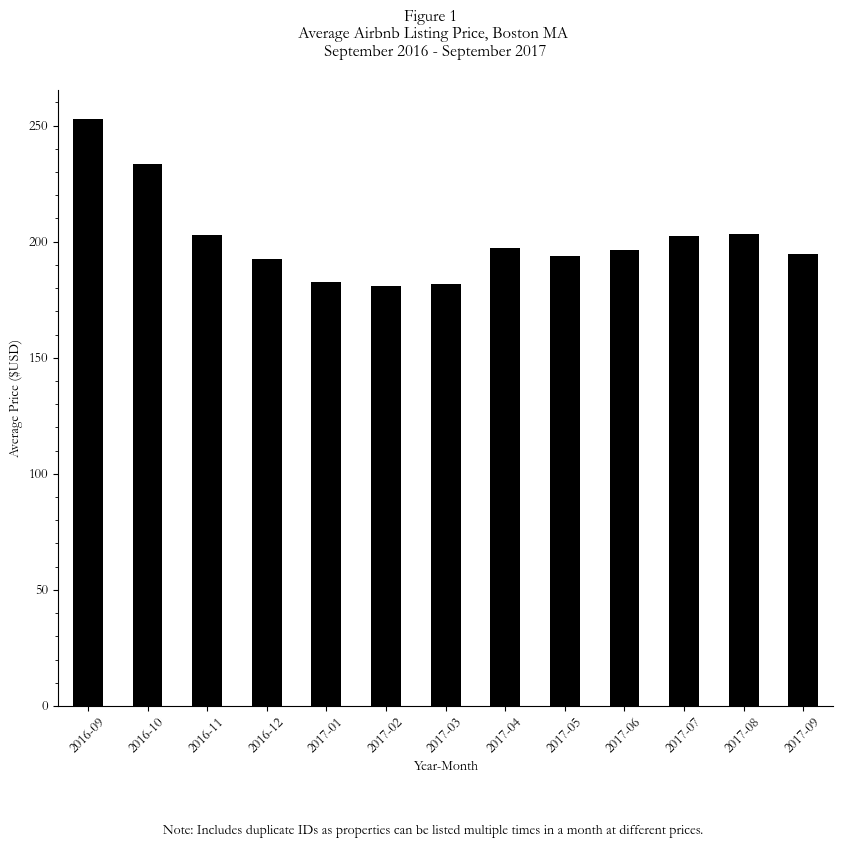

In [913]:
#Calculate the average listing price per month

#Calculate mean price per year-month
avg_list_price = CalLisCrime.groupby("year_month")["price"] \
                            .mean().reset_index()

#Convert "year_month" column to string
avg_list_price["year_month"] = avg_list_price["year_month"].astype(str)

#Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
avg_list_price.plot(x="year_month", y="price", kind="bar", ax=ax, 
                    legend=False, color="black")

#Cleaning

#Remove right and top spines
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

#Create title
fig.suptitle("Figure 1 \n Average Airbnb Listing Price, \
Boston MA \n September 2016 - September 2017")

#Set x label
ax.set_xlabel("Year-Month")

#Rotate x labels
plt.xticks(rotation=45)

#Set y label
ax.set_ylabel("Average Price ($USD)")

#Set y ticks to incriments of 50 for major ticks, 
#and set minor ticks to incriments of 10
ax.set_yticks(np.arange(0, 300, 50))  
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10))  

#Create note
plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can \
be listed multiple times in a month at different prices.", 
            ha="center", fontsize=10)

plt.show()

I visualized this because it is necessary to see if the average listing price increased during the month of the Boston Marathon. The jump in average price in April 2017 supports my hypothesis. However, the high average prices in September and October of 2016 make this jump appear less significant. This outcome could be due to seasonal variations or because only certain Airbnb's experience the marathon effect. It is therefore imperative to examine more granular data to better assess pricing trends. 

## 4.2. Scatter Plot of Daily Average Airbnb Listing Price 

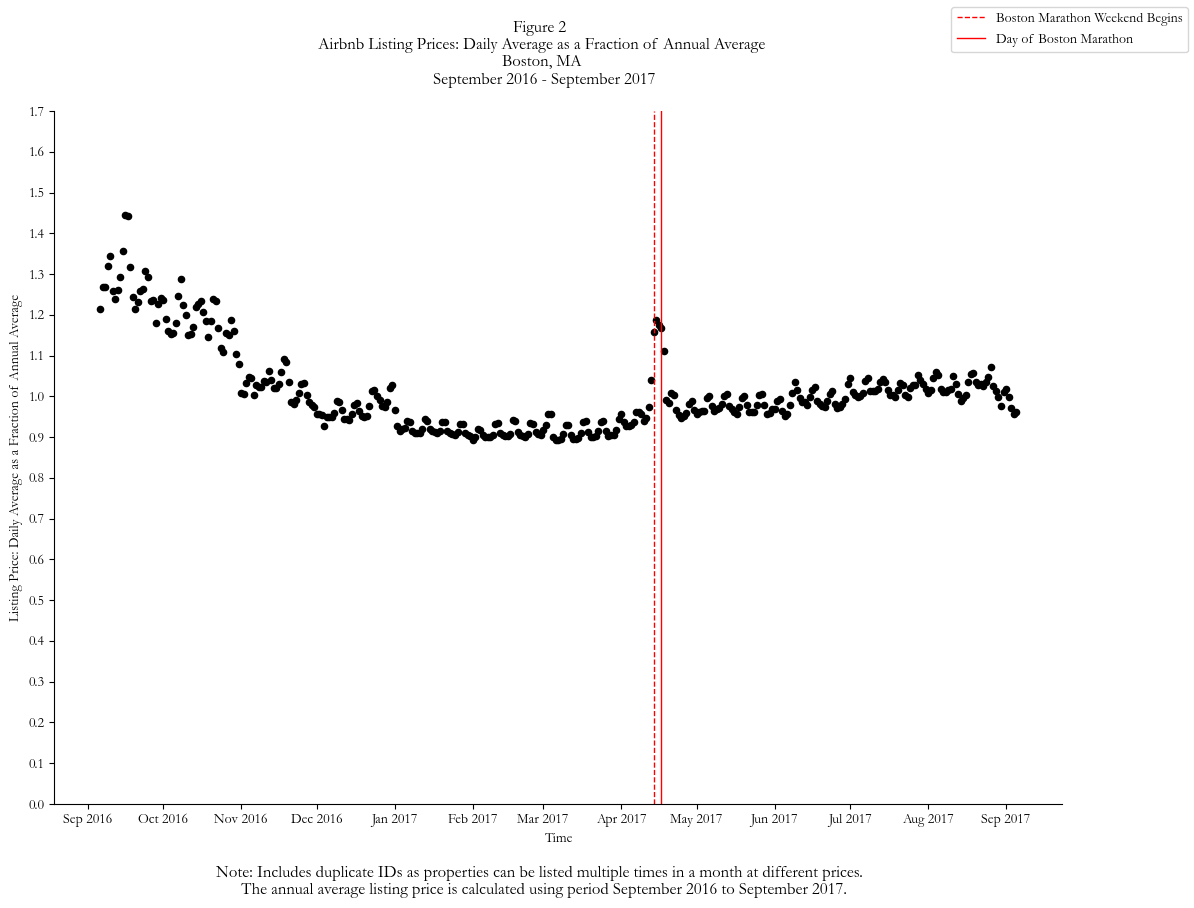

In [914]:
#Create temp dataset of average listing price per day
temp = CalLisCrime.groupby("date")["price"].mean().reset_index()

#Calculate average price over the whole study period
avg_price_year = calendar["price"].mean()

#Create column in temp for average daily price as a fraction of 
# average annual price
temp["price fraction"] = temp["price"] / avg_price_year

#Configure figure and axes
fig, ax = plt.subplots(figsize=(13, 9))

#Create line plot for average price per day
temp.plot(x="date", y="price fraction", ax=ax, kind="scatter", 
          legend=True, color="black")

#Create vertical lines indicating the day the Boston Marathon weekend 
# begins and the day of the Boston Marathon
ax.axvline(x=pd.to_datetime("2017-04-14"), color="red", 
           linestyle="--", linewidth=1, 
           label="Boston Marathon Weekend Begins")
ax.axvline(x=pd.to_datetime("2017-04-17"), color="red", 
           linestyle="-", linewidth=1, 
           label="Day of Boston Marathon")

#Cleaning

#Remove right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#Create y label
ax.set_ylabel("Listing Price: Daily Average as a Fraction of Annual Average")

#Set y ticks
ax.set_yticks(np.arange(0, 1.8, 0.1))
ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1))

#Create x label
ax.set_xlabel("Time")

#Label every month on x-axis
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter("%b %Y"))

#Create title
fig.suptitle("Figure 2 \n Airbnb Listing Prices: \
Daily Average as a Fraction of Annual Average \n \
Boston, MA \n September 2016 - September 2017")

#Place legend in upper right corner
fig.legend(loc="upper right")

plt.figtext(0.5, 0.01, "Note: Includes duplicate IDs as properties can be \
listed multiple times in a month at different prices. \n The annual average \
listing price is calculated using period September 2016 to September 2017.", \
ha="center", fontsize=12)

plt.show()


I visualized this plot because it better highlights the spike in listing prices during the Boston Marathon period, which is indicated by the two red vertical lines. Noticeably, the price spike immediately vanishes following the day of the Boston Marathon.

## 4.3. Density Histograms of Airbnb Listing Prices by Time

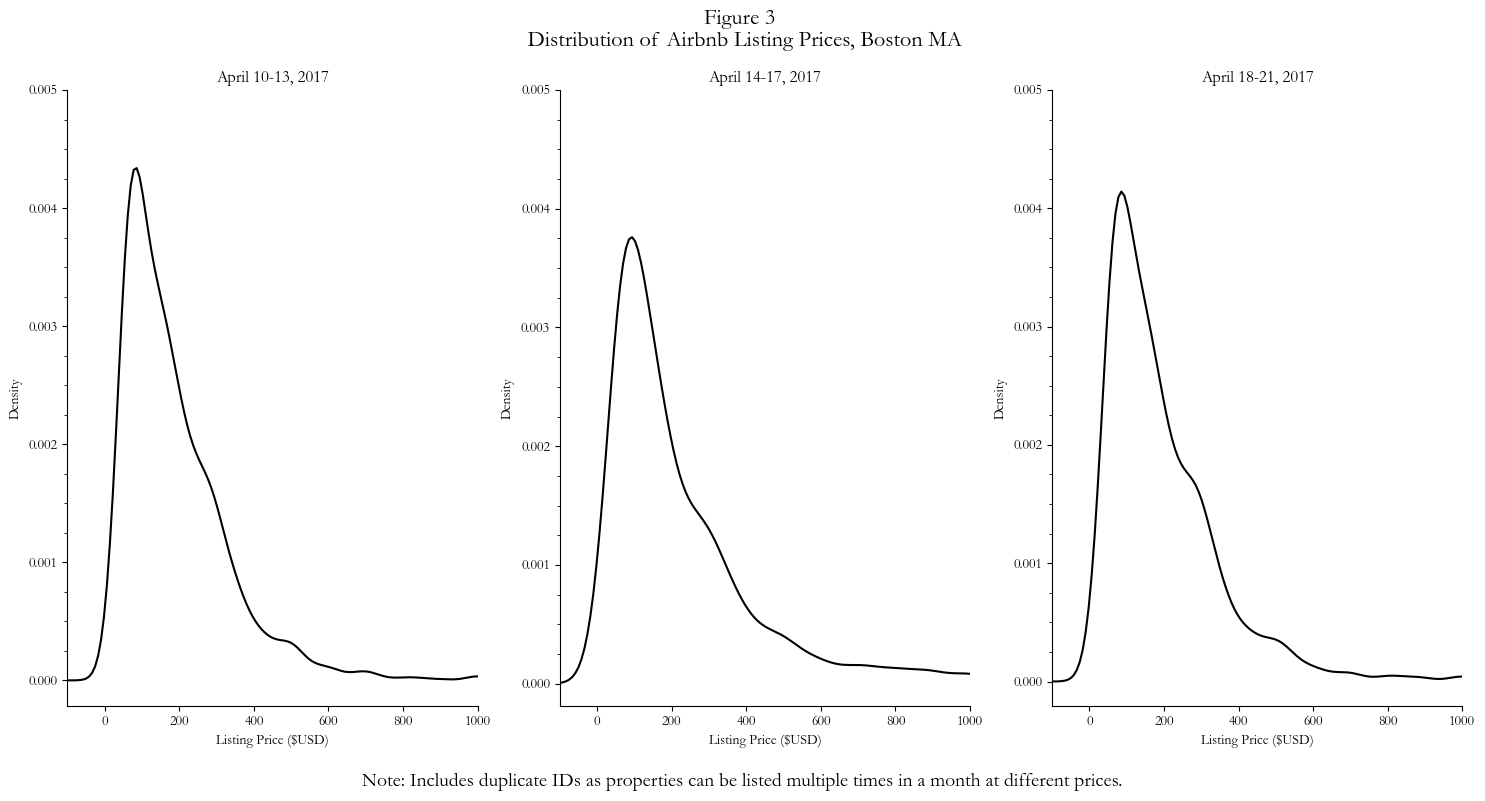

In [915]:
#Create temp datasets for April 10-13, 2017, April 14-17, 2017, 
# and April 18-21, 2017
april10_13 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-10") &
                            (CalLisCrime["date"] <= "2017-04-13")]
april14_17 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-14") &
                            (CalLisCrime["date"] <= "2017-04-17")]
april18_21 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-18") &
                            (CalLisCrime["date"] <= "2017-04-21")]

#Configure figure and axes, there are 3 axes and 1 figure
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

#Create April 10-13 histogram at axes[0]
april10_13.plot.density(y="price", ax=axes[0], legend=False, xlim=(-100, 1000), 
                   color="black") 

#Cleaning
#Remove right and top spines
axes[0].spines["right"].set_visible(False)   
axes[0].spines["top"].set_visible(False)

#Create title
axes[0].set_title("April 10-13, 2017")

#Create x label
axes[0].set_xlabel("Listing Price ($USD)")

#Set y ticks 
axes[0].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[0].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create April 14-17 histogram at axes[1]
april14_17.plot.density(y="price", ax=axes[1], legend=False, xlim=(-100, 1000), 
                   color = "black") 

#Cleaning
axes[1].spines["right"].set_visible(False)   
axes[1].spines["top"].set_visible(False)

axes[1].set_title("April 14-17, 2017")

axes[1].set_xlabel("Listing Price ($USD)")

axes[1].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[1].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create April 18-21 histogram at axes[1]
april18_21.plot.density(y="price", ax=axes[2], legend=False, xlim=(-100, 1000), 
                   color = "black") 

#Cleaning
axes[2].spines["right"].set_visible(False)   
axes[2].spines["top"].set_visible(False)

axes[2].set_title("April 18-21, 2017")

axes[2].set_xlabel("Listing Price ($USD)")

axes[2].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[2].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create title
fig.suptitle("Figure 3 \n Distribution of Airbnb Listing Prices, Boston MA",
             fontsize=16)

#Create note
plt.figtext(0.5, 0.01, "Note: Includes duplicate IDs as properties can \
be listed multiple times in a month at different prices.", 
            ha="center", fontsize=14)
plt.show()

I visualized this distribution to determine if there is a significant change in the distribution of prices due to the hypothesized demand surge brought about by the Boston Marathon. We see during the Boston Marathon period (April 14th to 17th) that the distribution of prices has a lower peak and a more gradual downward slope beyond this peak relative to both the before and after reference periods. This ultimately supports there being a temporary spike in prices due to the marathon. 

## 4.4. Box Plots of Airbnb Listing Prices by Distance to Marathon Finish Line and Time

The first section of code below calculates the distance of each neighbourhood's centroid to the Boston Marathon finish line.

There are 24 neighbourhoods in the Boston neighbourhoods shape file. Close neighbourhoods include the 8 closest neighbourhoods to the finish line, mid-range are the next 8 closest, and so on.

In [916]:
import geopandas as gpd
from shapely.geometry import Point

#Read Boston neighbourhoods shapefile
boston_neighbourhoods_temp = gpd.read_file(
    r"C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\"
    "Eco225\\ECO225Project\\"
    "boston_neighborhood_boundaries_approximated_by_2020_census_tracts.json")

#Establish marathon finish line coordinates
#Obtained from Google Maps: 
lat_f = 42.350125528073185
long_f = -71.0787799492581
#Create a Point object for the finish line
finish_point = Point(long_f, lat_f)

#Create a geodataframe for the finish line
#index[0] creates a single row
#Establish finish_point as the geometry column
#Establish CRS as EPSG:3857
finish_gdf = gpd.GeoDataFrame(
    index=[0], geometry=[finish_point], crs="EPSG:4326").to_crs(epsg=3857)
#Pull geometry from finish_gdf
finish_number = finish_gdf.geometry.iloc[0]

#Set neighbourhoods CRS to EPSG:4326
boston_neighbourhoods_temp = boston_neighbourhoods_temp.to_crs(epsg=3857)

#Create empty list to store distances
distances = []

#Loop through each neighbourhood and calculate distance to the finish line
for idx, rows in boston_neighbourhoods_temp.iterrows():
    #Find centroid of the neighbourhood
    centroid = rows["geometry"].centroid
    #Calculate distance to the finish line (in meters)
    distance = centroid.distance(finish_number)
    #Append distance to the list
    distances.append(distance)

#Add distances column to boston_neighbourhoods_temp
boston_neighbourhoods_temp["distance"] = distances

#Sort the neighbourhoods by distance to the finish line
boston_neighbourhoods_temp = boston_neighbourhoods_temp.sort_values(
    by="distance", ascending=True)


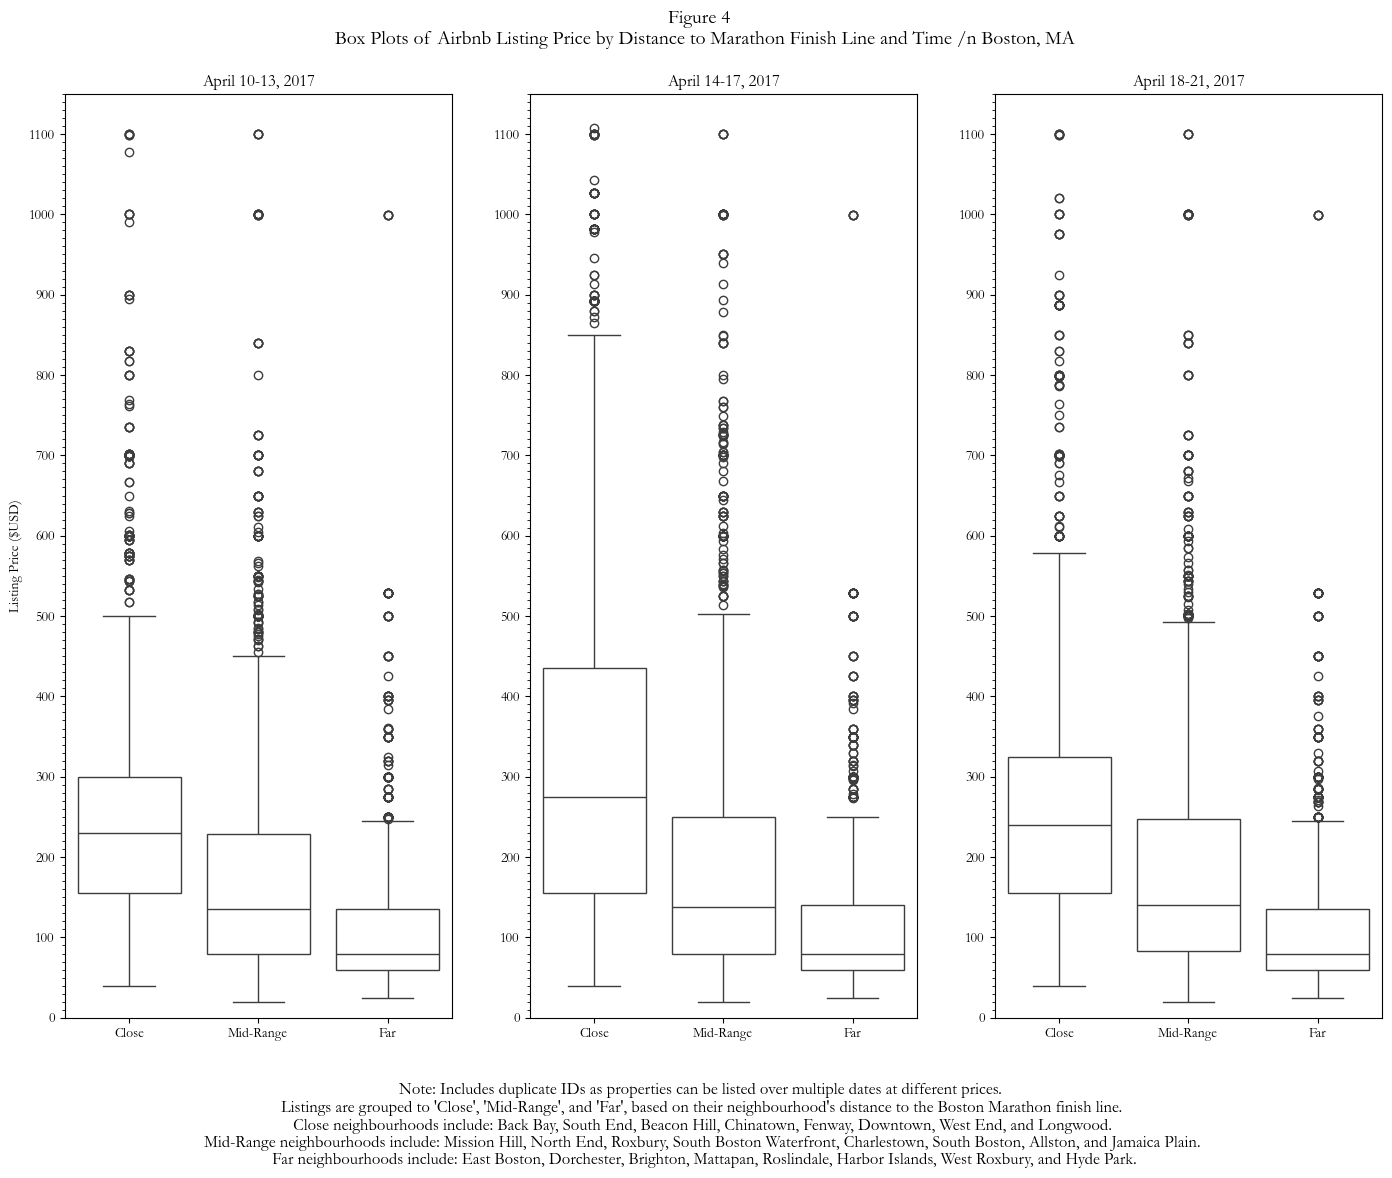

In [917]:
#Idea sourced from: 
#https://www.kaggle.com/code/kostyabahshetsyan/boston-airbnb-visualization

#Create 3 lists for 'close', 'mid-range', and 'far' neighbourhoods
close = ["Back Bay", "South End", "Beacon Hill", "Chinatown",
         "Fenway", "Downtown", "West End", "Longwood"]
mid_range = ["Mission Hill", "North End", "Roxbury",
             "South Boston Waterfront", "Charlestown",
             "South Boston", "Allston", "Jamaica Plain"]
far = ["East Boston", "Dorchester", "Brighton",
       "Mattapan", "Roslindale", "Harbor Islands",
       "West Roxbury", "Hyde Park"]

#Create filtered datasets for April 10-13, 2017, April 14-17, 2017, 
# and April 18-21, 2017
april10_13 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-10") &
                            (CalLisCrime["date"] <= "2017-04-13")]
april14_17 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-14") &
                            (CalLisCrime["date"] <= "2017-04-17")]
april18_21 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-18") &
                            (CalLisCrime["date"] <= "2017-04-21")]

#Configure figure and axes, there are 3 axes and 1 figure
fig, axes = plt.subplots(1, 3, figsize = (17, 12))

date = [april10_13, april14_17, april18_21]
date_str = ["April 10-13, 2017", "April 14-17, 2017", "April 18-21, 2017"]

index1 = 0
index2 = 0

for date in date:

       #Create dataset of April 10-13 by close, mid-range, and far neighbourhoods
       date_close = date[date["neighbourhood_cleansed"].isin(close)]
       date_mid_range = date[date["neighbourhood_cleansed"].isin(mid_range)]
       date_far = date[date["neighbourhood_cleansed"].isin(far)]

       #Keep only price column and rename price column to pice_close, 
       # price_mid_range, price_far
       date_close = date_close[["price"]].rename(columns={"price": "Close"})
       date_mid_range = date_mid_range[["price"]].rename(columns={
              "price": "Mid-Range"})
       date_far = date_far[["price"]].rename(columns={"price": "Far"})

       #Merge datasets 
       date_merged = pd.concat([date_close, date_mid_range, date_far], axis=1)

       sns.boxplot(data=date_merged, 
       ax=axes[index1], boxprops=dict(facecolor="none"))
       
       axes[index1].set_title(date_str[index2])

       axes[0].set_ylabel("Listing Price ($USD)")

       axes[index1].set_yticks(np.arange(0, 1151, 100)) 
       axes[index1].yaxis.set_minor_locator(mtick.MultipleLocator(10)) 

       axes[index1].set_ylim(0, 1150)
       
       index1 += 1
       index2 += 1

#Create title
fig.suptitle("Figure 4 \n Box Plots of Airbnb Listing Price by "
"Distance to Marathon " \
"Finish Line and Time /n Boston, MA", 
fontsize=14, y=0.95)

plt.figtext(0.5, -0.01, "Note: Includes duplicate IDs as "
"properties can be "\
"listed over multiple dates at different prices. \n Listings "
"are grouped to 'Close', " \
"'Mid-Range', and 'Far', based on their neighbourhood's "
"distance to the Boston " \
"Marathon finish line. \n Close neighbourhoods include: "
"Back Bay, South End, " \
"Beacon Hill, Chinatown, Fenway, Downtown, West End, and "
"Longwood. \n Mid-Range " \
"neighbourhoods include: Mission Hill, North End, "
"Roxbury, " \
"South Boston Waterfront, Charlestown, South Boston, "
"Allston, and " \
"Jamaica Plain. \n Far neighbourhoods include: East "
"Boston, Dorchester, " \
"Brighton, Mattapan, Roslindale, Harbor Islands, West "
"Roxbury, and Hyde Park.", 
ha="center", fontsize=12, wrap=True)

plt.show()


This figure allows me to assess if there was variation in the change in listing prices from before, during, and after the Boston Marathon period, based on a listing's distance to the Boston Marathon finish line. (Brady, 2017; City of Boston, 2009). This then helps me determine my treatment and control groups.

This figure shows that listings close to the Boston Marathon finish line had a noticeable change in the distribution of listing prices, with a higher median, 75th percentile, and upper whisker during the marathon period compared to before this period. Also, this change appears to immediately revert following the marathon period.

'Mid-range' listings, meanwhile, have a slightly increased 75th percentile and upper whisker during the marathon period. However, this reverts after the marathon. In contrast, there is not a noticeable change in the distribution of 'far' listings over all three periods.

This figure ultimately supports my hypothesis as it shows that 'close' listings experience a relatively large but temporary change in the distribution of listing prices during the marathon period relative to the two other listing groups. 

# Project 2

## 5. The Message

In Boston, MA, in 2017, there was likely a 'Boston Marathon effect' on Airbnb listing prices that only listings close to the marathon experienced significantly. This marathon effect was likely brought about by an increase in demand for Airbnbs near the marathon route.

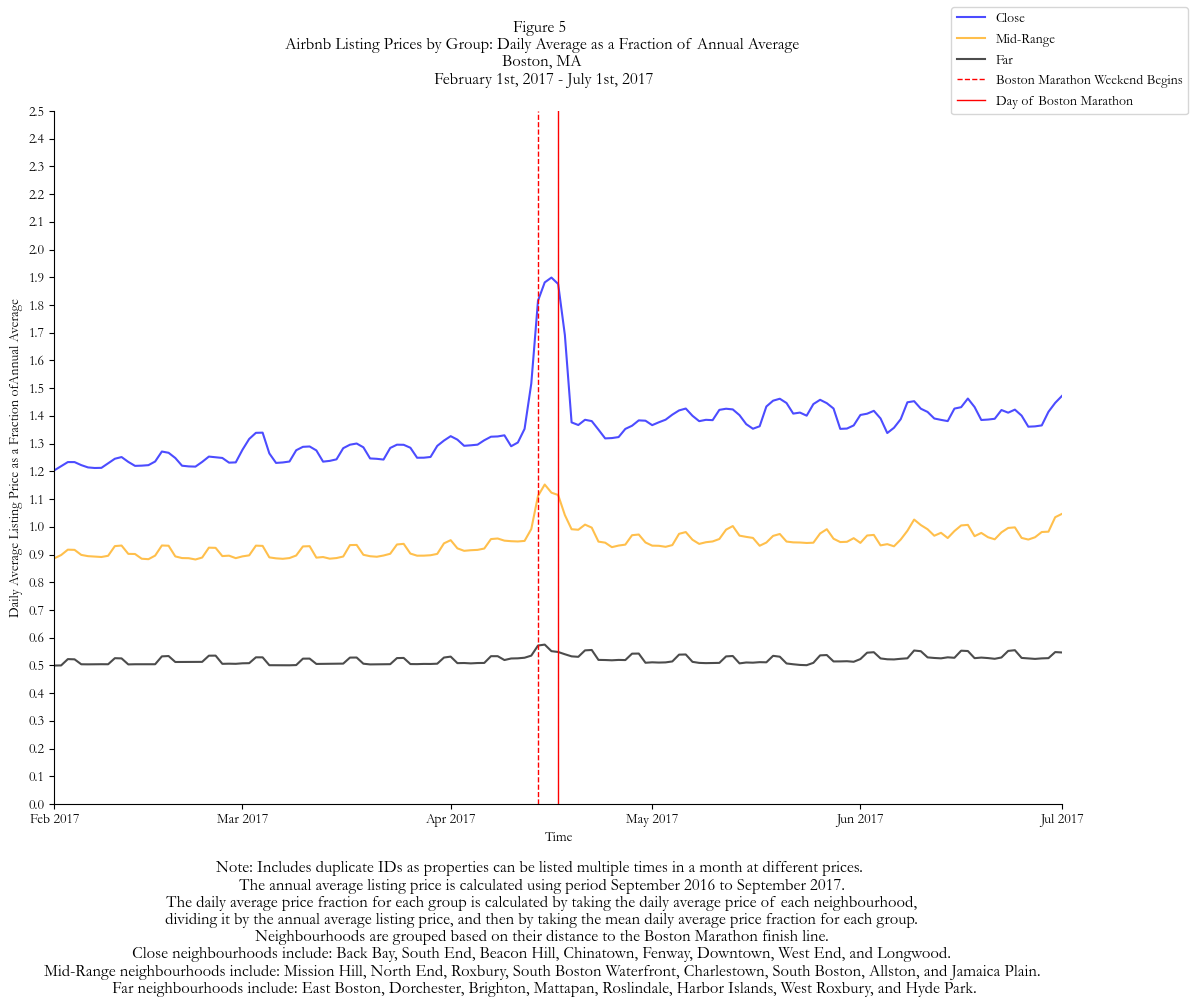

In [918]:
message_frame = CalLisCrime.copy()

#Filter to include only days between Feb 1 and July 1, 2017
message_frame = message_frame[(message_frame["date"] >= "2017-02-01") &
                            (message_frame["date"] <= "2017-07-01")]

#Get daily average price for each neighbourhood
message_frame = message_frame.groupby(["neighbourhood_cleansed", "date"]) \
                            ["price"].mean().reset_index()

#Calculate daily average as a fraction of annual average price
avg_price_year = calendar["price"].mean()
message_frame["price fraction"] = message_frame["price"] / avg_price_year

close = ["Back Bay", "South End", "Beacon Hill", "Chinatown",
         "Fenway", "Downtown", "West End", "Longwood"]
mid_range = ["Mission Hill", "North End", "Roxbury",
             "South Boston Waterfront", "Charlestown",
             "South Boston", "Allston", "Jamaica Plain"]
far = ["East Boston", "Dorchester", "Brighton",
       "Mattapan", "Roslindale", "Harbor Islands",
       "West Roxbury", "Hyde Park"]

#Create filtered datasets for close, mid-range, and far neighbourhoods
close = message_frame[message_frame["neighbourhood_cleansed"].isin(close)]
mid_range = message_frame[message_frame["neighbourhood_cleansed"].isin(mid_range)]
far = message_frame[message_frame["neighbourhood_cleansed"].isin(far)]

#Configure figure and axes
fig, ax = plt.subplots(figsize=(13, 9))

#Get mean price fraction for each day among neighbourhoods in 
# close, mid-range, and far
close.groupby("date")["price fraction"].mean().plot(ax=ax, 
       alpha=0.7, label="Close", legend=False, color="blue")
mid_range.groupby("date")["price fraction"].mean().plot(ax=ax, 
       alpha=0.7, label="Mid-Range", legend=False, color="orange")
far.groupby("date")["price fraction"].mean().plot(ax=ax, 
       alpha=0.7, label="Far", legend=False, color="black")

#Create vertical line indicating the friday before the Boston Marathon 
# and the day of the Boston Marathon
ax.axvline(x=pd.to_datetime("2017-04-14"), color="red", 
           linestyle="--", linewidth=1, 
           label="Boston Marathon Weekend Begins")
ax.axvline(x=pd.to_datetime("2017-04-17"), color="red", 
           linestyle="-", linewidth=1,
           label="Day of Boston Marathon")

#Cleaning

#Remove right and top spines
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

#Create y label
ax.set_ylabel("Daily Average Listing Price as a Fraction ofAnnual Average")

#Create x label
ax.set_xlabel("Time")

#Label x axis with month and year
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter("%b %Y"))
ax.xaxis.set_minor_locator(mtick.NullLocator())

#Create title
fig.suptitle("Figure 5 \n Airbnb Listing Prices by Group: \
Daily Average as a Fraction of Annual Average \
\n Boston, MA \n February 1st, 2017 - July 1st, 2017")

#Set y ticks
ax.set_yticks(np.arange(0, 2.51, 0.1)) 
ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1)) 

#Place legend in upper right corner
fig.legend(loc="upper right")

plt.figtext(0.5, -0.1, "Note: Includes duplicate IDs as properties can be "
"listed multiple times in a month at different prices. \n The annual average "
"listing price is calculated using period September 2016 to September 2017. "
"\n The daily average price fraction for each group is calculated by taking the "
"daily average price of each neighbourhood, \n dividing it by the annual average listing price, "
"and then by taking the mean daily average price fraction for each group. \n "
"Neighbourhoods are grouped based on their distance to the Boston Marathon finish line. "
"\n Close neighbourhoods include: Back Bay, South End, " 
"Beacon Hill, Chinatown, Fenway, Downtown, West End, and Longwood. \n Mid-Range " 
"neighbourhoods include: Mission Hill, North End, Roxbury, " 
"South Boston Waterfront, Charlestown, South Boston, Allston, and " 
"Jamaica Plain. \n Far neighbourhoods include: East Boston, Dorchester, " 
"Brighton, Mattapan, Roslindale, Harbor Islands, West Roxbury, and Hyde Park.",
ha="center", fontsize=12)

plt.show()



# 6. Maps

## 6.1. Boston Neighbourhoods by Distance to Boston Marathon Finish Line

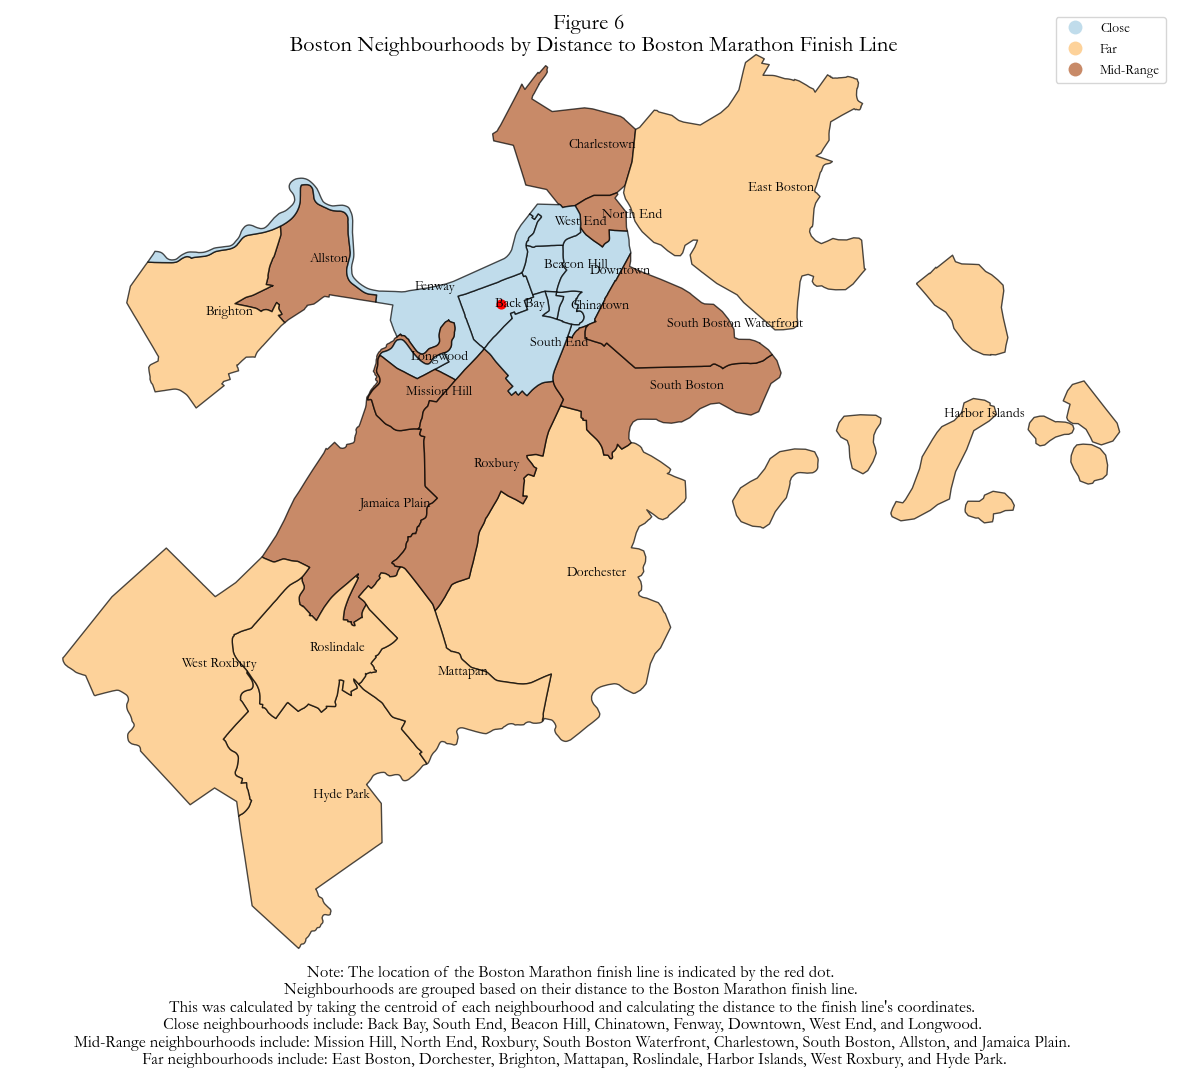

In [919]:
close = ["Back Bay", "South End", "Beacon Hill", "Chinatown",
         "Fenway", "Downtown", "West End", "Longwood"]
mid_range = ["Mission Hill", "North End", "Roxbury",
             "South Boston Waterfront", "Charlestown",
             "South Boston", "Allston", "Jamaica Plain"]
far = ["East Boston", "Dorchester", "Brighton",
       "Mattapan", "Roslindale", "Harbor Islands",
       "West Roxbury", "Hyde Park"]


boston_neighbourhoods_temp2 = gpd.read_file(
       r"C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\"
       "Eco225\\ECO225Project\\"
       "boston_neighborhood_boundaries_approximated_by_"
       "2020_census_tracts.json")

boston_neighbourhoods_temp2["Proximity"] = ""

for ix, row in boston_neighbourhoods_temp2.iterrows():
       if row["neighborhood"] in close:
              boston_neighbourhoods_temp2.at[ix, 
                     "Proximity"] = "Close"
       elif row["neighborhood"] in mid_range:
              boston_neighbourhoods_temp2.at[ix, 
                     "Proximity"] = "Mid-Range"
       elif row["neighborhood"] in far:
              boston_neighbourhoods_temp2.at[ix, 
                     "Proximity"] = "Far"

fig, gax = plt.subplots(figsize=(15, 15))

boston_neighbourhoods_temp2.plot(column="Proximity", ax=gax, 
                                  legend=True, edgecolor="black", 
                                   cmap="Paired", alpha=0.7)

finish_gdf = finish_gdf.to_crs(boston_neighbourhoods_temp2.crs)

#Plot marathon finish line
finish_gdf.plot(ax=gax, color="red", markersize=40, 
       label="Boston Marathon Finish Line")

temp = boston_neighbourhoods_temp2.to_crs("EPSG:3857")
centroids = temp.centroid.to_crs(boston_neighbourhoods_temp2.crs)

for x, y, label in zip(
      centroids.x, centroids.y, 
      boston_neighbourhoods_temp2["neighborhood"]):
              gax.text(x, y, label, fontsize=10)

#Create title
gax.set_title("Figure 6 \n Boston Neighbourhoods by Distance"
" to Boston Marathon Finish Line",
              fontsize=16, y=0.95)

gax.set_axis_off()

#Create note
plt.figtext(0.5, 0.12, "Note: The location of the Boston Marathon "
"finish line is indicated by the red dot. \n"
"Neighbourhoods are grouped based on their distance to the Boston "
"Marathon finish line. \n This was calculated by taking the centroid "
"of each neighbourhood and calculating the distance to the "
"finish line's coordinates. \n Close neighbourhoods include: Back Bay, "
"South End, Beacon Hill, Chinatown, Fenway, Downtown, West End, "
"and Longwood. \n Mid-Range neighbourhoods include: Mission Hill, "
"North End, Roxbury, South Boston Waterfront, Charlestown, "
"South Boston, Allston, and Jamaica Plain. \n Far neighbourhoods "
"include: East Boston, Dorchester, Brighton, Mattapan, Roslindale, "
"Harbor Islands, West Roxbury, and Hyde Park.", ha="center", fontsize=12)

plt.show()



Figure 6 displays Boston neighbourhoods with colour indicating if that neighbourhood belongs to the 'Close', 'Mid-Range', or 'Far' group.

## 6.2. Boston Neighbourhoods' Airbnb Density

In [920]:
#Obtained from: https://data.boston.gov/dataset/neighborhood-demographics
population_by_neighbourhood = {
    "Allston": 19363,
    "Back Bay": 18176,
    "Beacon Hill": 9751,
    "Brighton": 51785,
    "Charlestown": 18901,
    "Dorchester": 125947,
    "Downtown": 17581,
    "East Boston": 46655,
    "Fenway": 32598,
    "Harbor Islands": 322,
    "Hyde Park": 37094,
    "Jamaica Plain": 39314,
    "Longwood": 5389,
    "Mattapan": 25586,
    "Mission Hill": 17406,
    "North End": 9271,
    "Roslindale": 29206,
    "Roxbury": 52944,
    "South Boston": 36212,
    "South Boston Waterfront": 3443,
    "South End": 32040,
    "West End": 6173,
    "West Roxbury": 33930
}


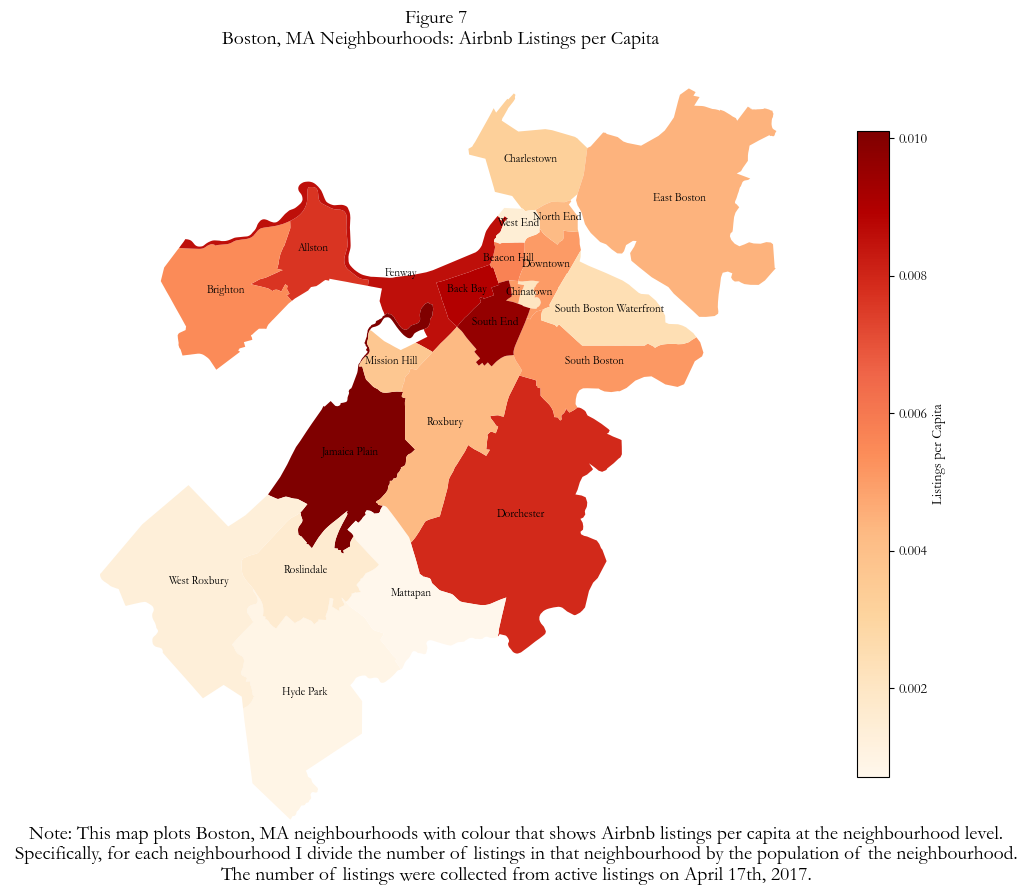

In [921]:
nei_capita = CalLisCrime.copy()

# Filter for April 17th, 2017
nei_capita = nei_capita[nei_capita["date"] == "2017-04-17"]

# Drop duplicate listings
nei_capita = nei_capita.drop_duplicates(subset=["id"], keep="first")

# Group by neighbourhood and count unique properties per neighbourhood
nei_capita = nei_capita.groupby("neighbourhood_cleansed")["id"].count() \
                    .reset_index()

#Rename columns
nei_capita.rename(columns={"id": "count", "neighbourhood_cleansed": 
                           "neighborhood"}, 
                 inplace=True)

boston_neighbourhoods = gpd.read_file(r"C:\\Users\\eliea\\Desktop\\"
    "UofTYear3\\Term_2\\"
    "Eco225\\ECO225Project\\"
    "boston_neighborhood_boundaries_approximated_by_2020_census_tracts.json")

#Merge datasets
nei_capita = nei_capita.merge(boston_neighbourhoods, on="neighborhood", 
                              how="left")

#Divide count by population to get Airbnb listings per capita
for population in population_by_neighbourhood:
        nei_capita["Listings per Capita"] = nei_capita["count"] / \
            population_by_neighbourhood[population]

#Drop rows with NaN geometry
nei_capita = nei_capita.dropna(subset=["geometry"])

#Convert to GeoDataFrame
nei_capita = gpd.GeoDataFrame(nei_capita, geometry="geometry")

#Convert epsg to 32619
nei_capita = nei_capita.to_crs(epsg=32619)

fig, gax = plt.subplots(figsize=(12, 12))

#Plot neighbourhoods with color for share of listings
nei_capita.plot(column="Listings per Capita", cmap="OrRd", ax=gax, legend=True, 
               legend_kwds={"label": "Listings per Capita", 
                            "shrink": 0.7})

#Label neighbourhoods
#Centroid: 
#https://shapely.readthedocs.io/en/2.0.6/reference/shapely.centroid.html
for x, y, label in zip(nei_capita.geometry.centroid.x, 
                       nei_capita.geometry.centroid.y, 
                       nei_capita["neighborhood"]): 
        gax.text(x, y, label, fontsize=8, ha="center")

#Cleaning
#Remove all spines
gax.spines["top"].set_visible(False)
gax.spines["right"].set_visible(False)
gax.spines["left"].set_visible(False)
gax.spines["bottom"].set_visible(False)

#Remove x ticks
gax.set_xticks([])
gax.set_yticks([])

gax.set_title(
    "Figure 7 \n Boston, MA Neighbourhoods: Airbnb Listings per Capita",
    fontsize=14)

#Add a note
plt.figtext(0.5, 0.14, "Note: This map plots Boston, MA neighbourhoods with colour " \
    "that shows Airbnb listings per capita at the neighbourhood level." \
    "\n Specifically, for each neighbourhood I divide the number of listings in " \
    "that neighbourhood by the population of the neighbourhood. \n" \
    "The number of listings were collected from active listings on April 17th, 2017.", 
    ha="center", fontsize=14)

plt.show()

This visualization highlights the significant presence of Airbnb's in the downtown region, especially in Back Bay, Fenway, and the South End, relative to neighbourhoods, such as West Roxbury, that are far from the downtown core. This makes sense as the downtown areas likely attract more tourists who are seeking short term rentals. Interestingly, Jamaica Plain and Dorchester exhibit a noticeably higher Airbnb presence compared to other 'mid-range' neighbourhoods like Roxbury. 

Ultimately, this map allows me to identify which neighbourhoods primarily drive Airbnb listing price trends, as neighbourhoods with more listings per capita will exert greater influence on price dynamics.

## 6.3. Boston Airbnb Listings: Percent Change in Price Before & During the Boston Marathon

In [922]:
# Create 2 temp datasets which only includes a day the week before the marathon and
#the day of the marathon
# Only keep the id and price columns
pre_marathon = CalLisCrime[CalLisCrime["date"] == "2017-04-10"][["id", "price"]]
during_marathon = CalLisCrime[CalLisCrime["date"] == "2017-04-17"][["id", "price"]]

# Rename columns
pre_marathon.rename(columns={"price": "pre_marathon_price"}, inplace=True)
during_marathon.rename(columns={"price": "during_marathon_price"}, inplace=True)

# Merge the two dataframes on id
price_comparison = pre_marathon.merge(during_marathon, on="id", how="inner")

#Drop properties with NaN values
price_comparison.dropna(inplace=True)

#Calculate the difference in price
price_comparison["Difference"] = price_comparison["during_marathon_price"] \
      - price_comparison["pre_marathon_price"]

#Create column for percent change in price
price_comparison["Percent Change"] = (price_comparison["Difference"] \
                                       / price_comparison["pre_marathon_price"]) \
                                     * 100

#Drop outliers (ie. if % change > 300%)
price_comparison = price_comparison[price_comparison["Percent Change"] <= 300]

price_comparison.set_index("id", inplace=True)

In [923]:
#Create temp dataset which has latitude, longitude, and id of
#each property
temp1 = CalLisCrime[["id", "latitude", "longitude"]].copy()

#Zip latitude and longitude to create property_coords column
temp1["property_coords"] = list(zip(temp1.longitude, temp1.latitude))

#Drop duplicate listings
temp1.drop_duplicates(subset=["id"], keep="last", inplace=True)

#Keep only id and property_coords columns
temp1 = temp1[["id", "property_coords"]]

#Drop rows with NaN id
temp1.dropna(subset=["id"], inplace=True)

#Set index to id
temp1.set_index("id", inplace=True)

#Merge temp1 with price_comparison to have property_coords with the 
#price comparison dataset
price_comparison = price_comparison.merge(temp1, on="id", how="right")

#Drop if 0 in difference column
price_comparison1 = price_comparison[price_comparison["Difference"] != 0]

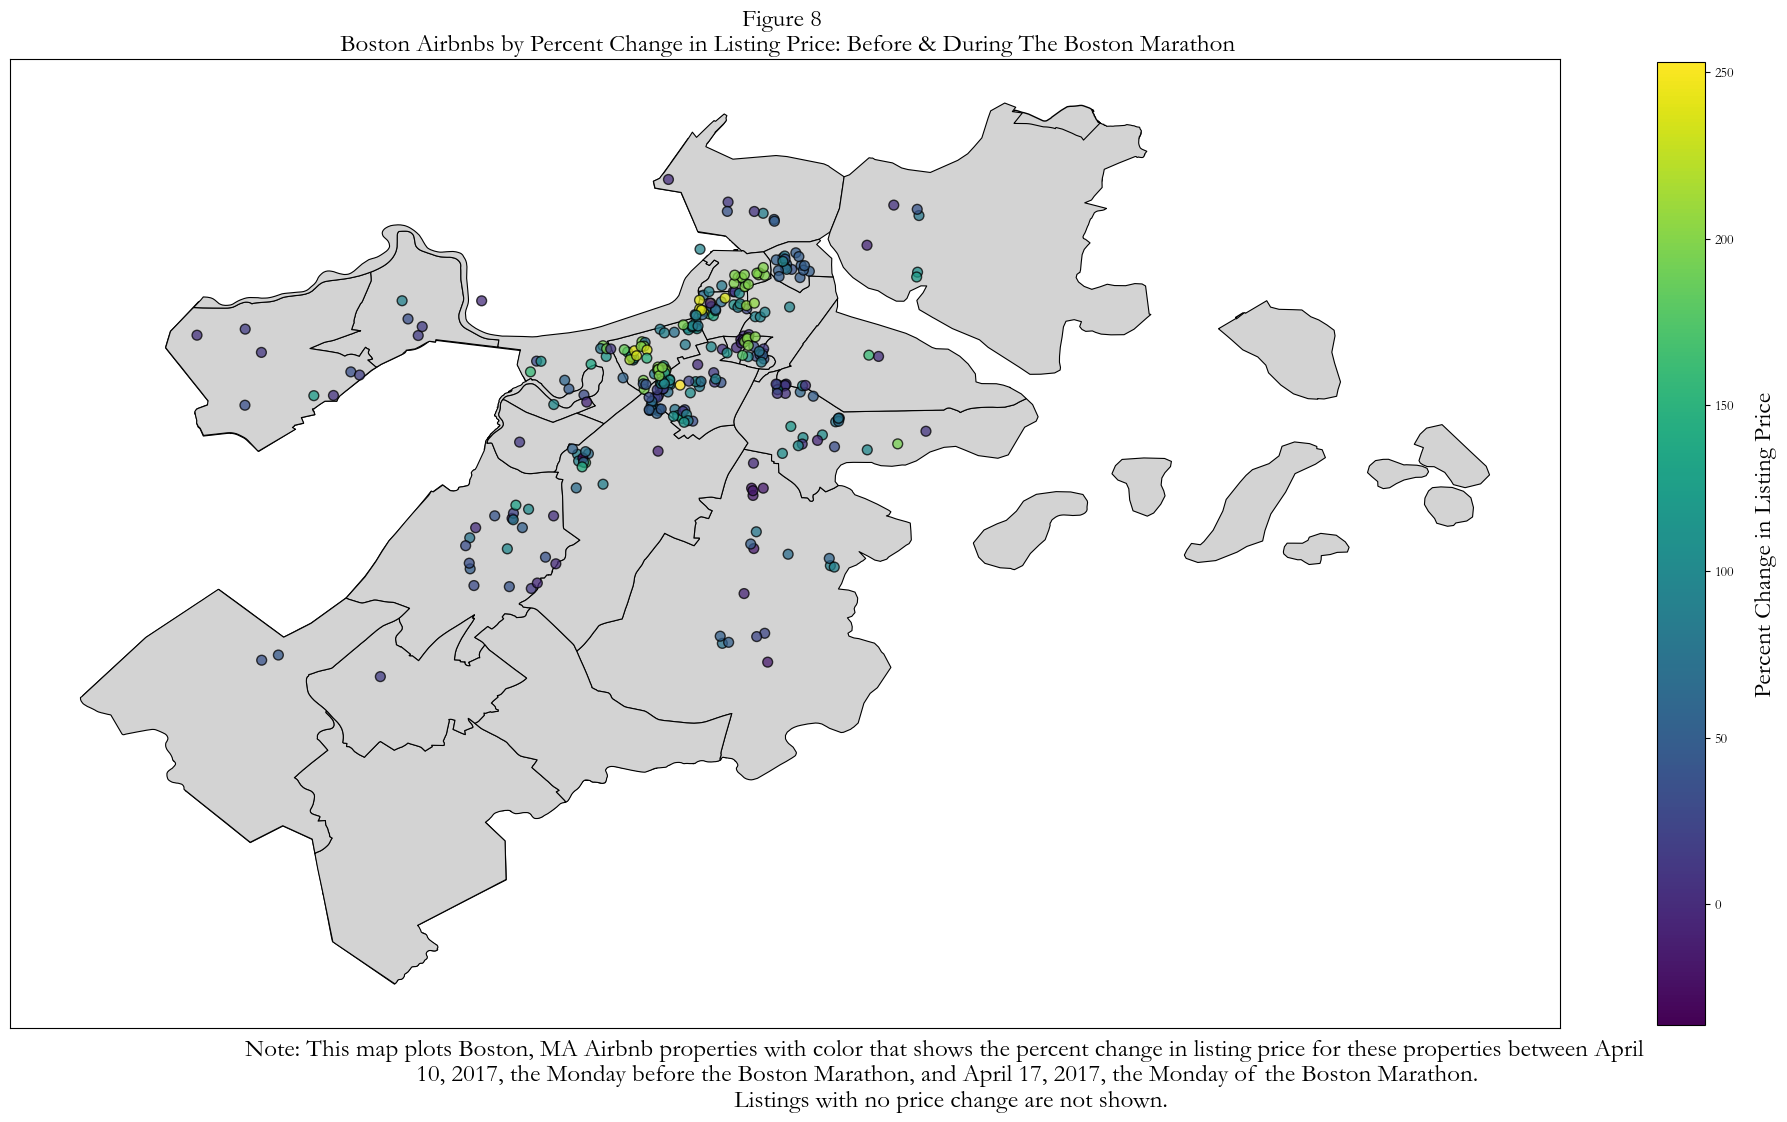

In [924]:
#Prevents setting with copy warning
price_comparison1 = price_comparison1.copy()

#Convert property_coords to Point
price_comparison1["property_coords"] = price_comparison1[
    "property_coords"].apply(Point)

#Convert price_comparison1 to GeoDataFrame called price_comparison_geo
price_comparison_geo = gpd.GeoDataFrame(price_comparison1, \
                                        geometry="property_coords")

boston = gpd.read_file(r"C:\\Users\\eliea\\Desktop\\UofTYear3\\"
    "Term_2\\Eco225\\ECO225Project\\"
    "city_of_boston_outline_boundary_water_excluded.json")

boston_neighbourhoods = \
gpd.read_file(r"C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\"
    "Eco225\\ECO225Project\\"
    "boston_neighborhood_boundaries_approximated_"
    "by_2020_census_tracts.json")

# Create the plot
fig, gax = plt.subplots(figsize=(25, 25))

boston.plot(ax=gax, edgecolor="black", linewidth=1, color="lightgrey")

#Plot boston_neighbourhoods
boston_neighbourhoods.plot(ax=gax, edgecolor="black", linewidth=0.8,
                           color="lightgrey")

#Plot price_comparison_geo and create a color gradient for percent change
price_comparison_geo.plot( ax=gax, column="Percent Change", cmap="viridis", 
    markersize=50, edgecolor="black", alpha=0.75, legend=True,
    legend_kwds={"label": "Percent Change in Listing Price", "shrink": 0.5})

#Cleaning

#Clean color bar
cbar = gax.get_figure().get_axes()[1] 
cbar.set_ylabel("Percent Change in Listing Price", fontsize=18, labelpad=15)

#Create title
gax.set_title("Figure 8 \n Boston Airbnbs by Percent Change in Listing Price: " \
               "Before & During The Boston Marathon", 
              fontsize=18)

#Remove ticks
gax.set_xticks([])
gax.set_yticks([])

#Add a note
plt.figtext(0.5, 0.27, "Note: This map plots Boston, MA Airbnb properties with color that " \
            "shows the percent change in listing price for these properties between April \n " \
            "10, 2017, the Monday before the Boston Marathon, and April 17, 2017, the " \
            "Monday of the Boston Marathon. \n Listings with no price change " \
            "are not shown.", ha="center", fontsize=18)

plt.show()

This map demonstrates that most listings which altered their price were in the downtown core. We can see that some listings in the downtown core increased their price by as much as 200 to 250 percent. In contrast, listings farther from the downtown core, which do have a change in price, are mostly concentrated in the 'mid-range' group of neighbourhoods. However, these 'mid-range' listings do not increase their prices by as much compared to downtown listings. There is also only a handful of listings in the 'far' group of neighbourhoods which change their price in response to the marathon. 

This map supports my hypothesis that it was mostly Airbnb listings near the downtown Boston Marathon route which increased their prices in response to a hypothesized demand surge brought about by the Boston Marathon.

## 6.4. Boston Airbnbs: Average Change in Price by Neighbourhood

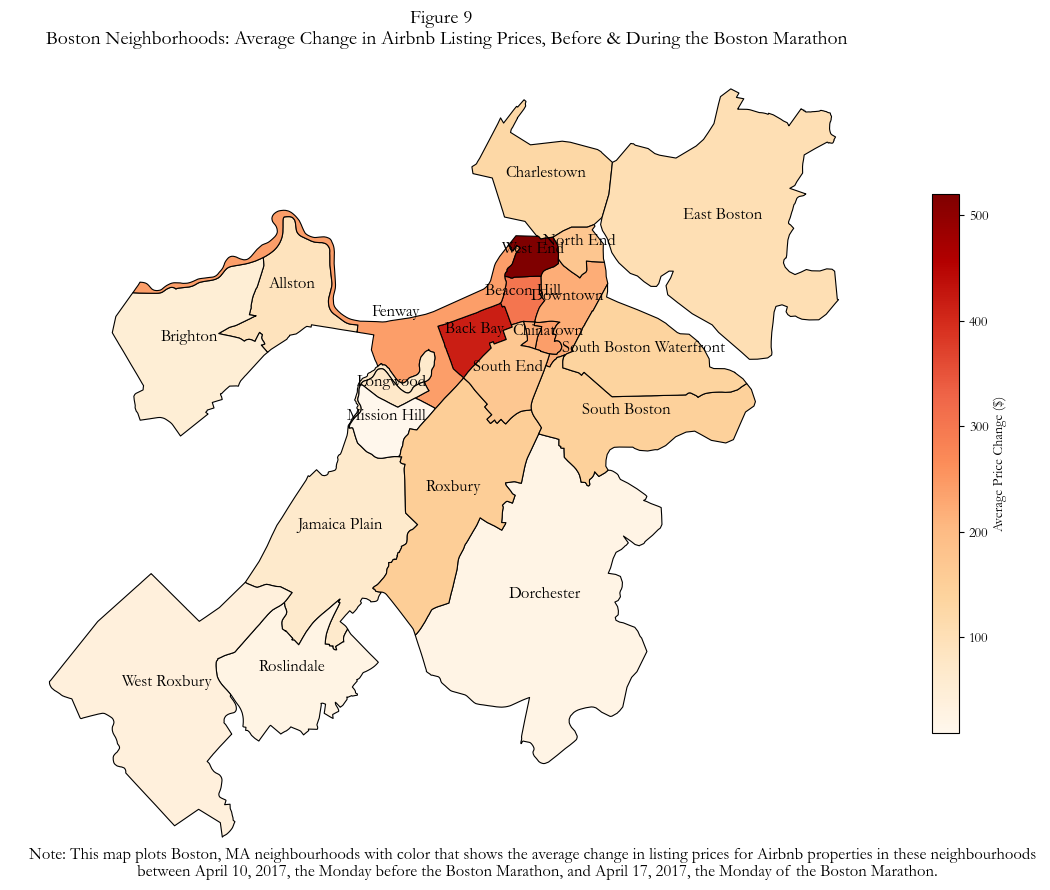

In [925]:
boston_neighbourhoods = \
gpd.read_file(r"C:\\Users\\eliea\\Desktop\\UofTYear3\\"
    "Term_2\\Eco225\\ECO225Project\\"
    "boston_neighborhood_boundaries_approximated_by_"
    "2020_census_tracts.json")

#Documentation: 
# https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html
price_comparison_geo.set_crs(epsg=4326, inplace=True)
price_comparison_geo = gpd.sjoin(price_comparison_geo, 
                    boston_neighbourhoods, how="left", predicate="within")

#Group price_comparison_geo by neighbourhood and calculate average price change
#Store results in neighborhood_price_change
neighborhood_price_change = price_comparison_geo.groupby(
    price_comparison_geo["neighborhood"])["Difference"].mean().reset_index()

#Merge neighborhood_price_change with boston_neighbourhoods
boston_neighborhoods = boston_neighbourhoods.merge(
    neighborhood_price_change, on="neighborhood", how="left")

#Get centroid of each neighbourhood
boston_neighborhoods = boston_neighborhoods.to_crs(epsg=26986) 
boston_neighborhoods["centroid"] = boston_neighborhoods.geometry.centroid  
boston_neighborhoods["centroid"] = boston_neighborhoods["centroid"].to_crs(
    epsg=4326)
boston_neighborhoods = boston_neighborhoods.to_crs(epsg=4326)

#Create plot
fig, ax = plt.subplots(figsize=(14, 14))

#Plot neighbourhoods with color for average price change
boston_neighborhoods.plot(ax=ax, column="Difference", cmap="OrRd",
    edgecolor="black", linewidth=0.8, legend=True,
    legend_kwds={"label": "Average Price Change ($)", "shrink": 0.5}
)

#Create list of unique neighbourhoods
valid_neighborhoods = boston_neighborhoods["neighborhood"].unique()
#Drop Mattapan and Hyde Park 
valid_neighborhoods = valid_neighborhoods[valid_neighborhoods != "Mattapan"]
valid_neighborhoods = valid_neighborhoods[valid_neighborhoods != "Hyde Park"]

#Label neighbourhoods
for idx, row in boston_neighborhoods.iterrows():
    #Only label neighbourhoods in valid_neighbourhoods
    if row["neighborhood"] in valid_neighborhoods:  
        plt.annotate(
            text=row["neighborhood"],
            xy=(row["centroid"].x, row["centroid"].y),
            xytext=(0, 3),  
            textcoords="offset points",
            fontsize=12,
            color="black",
            ha="center"
        )

#Remove spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

#Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Labels and title
ax.set_title("Figure 9 \n "
"Boston Neighborhoods: Average Change in Airbnb Listing Prices, " \
"Before & During the Boston Marathon", 
fontsize=14)

plt.figtext(0.5, 0.2, "Note: This map plots Boston, MA neighbourhoods with color that " \
            "shows the average change in listing prices for Airbnb properties in these neighbourhoods " \
            "\n between April 10, 2017, the Monday before the Boston Marathon, and April 17, "
            "2017, the Monday of the Boston Marathon.", ha="center", fontsize=12)

plt.show()


As shown above, this map demonstrates that downtown neighbourhoods had a higher average price change in response to the marathon relative to 'mid-range' neighbourhoods and 'far' neighbourhoods. Once again, this supports my hypothesis that only 'close' neighbourhoods experienced a 'marathon effect'.

# 7. Difference in Differences Regression Analysis

## 7.1. Correlation Matrix

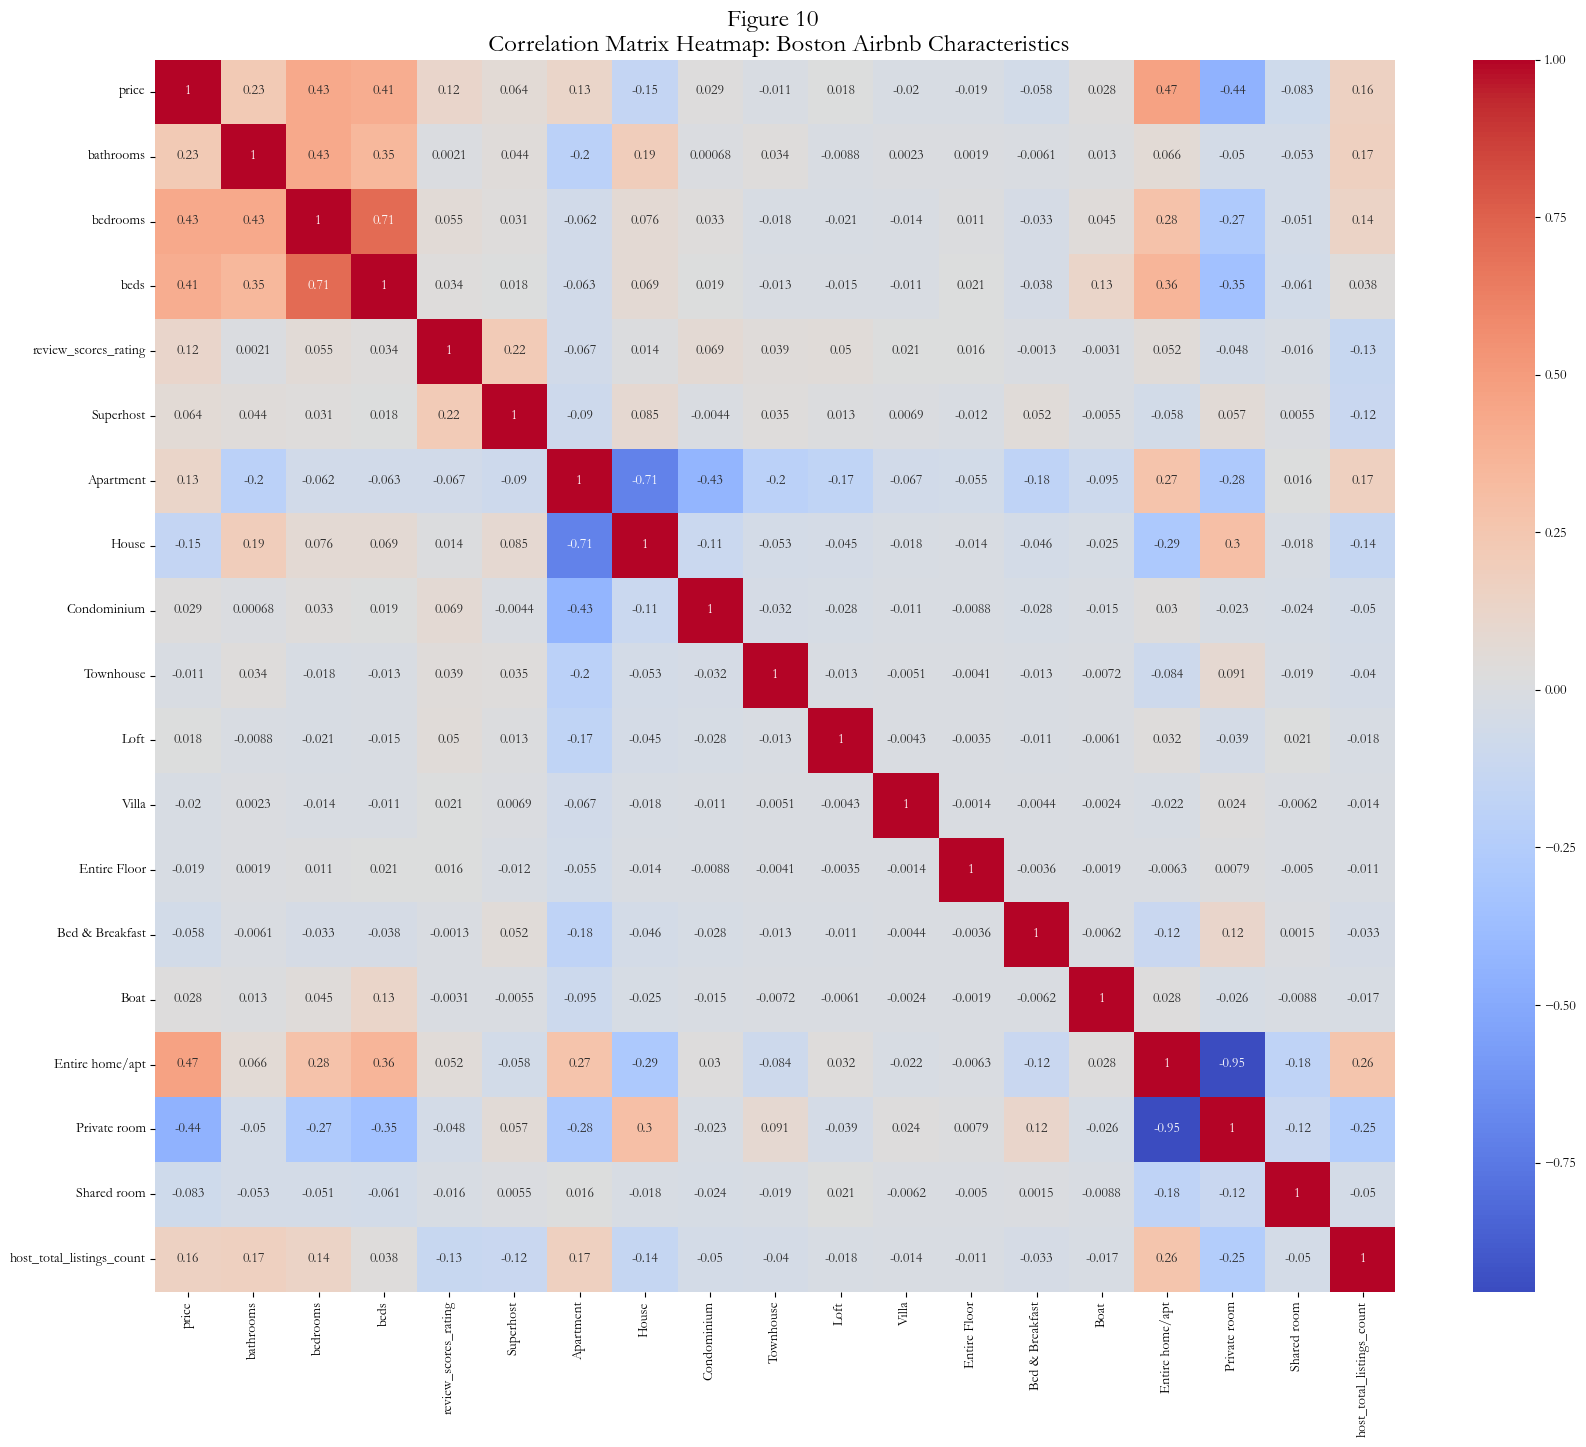

In [926]:
#Exclude "Camper/RV" as not enough data points to be meaningful
#Exclude "Other" property type
#Guesthouse and Dorm are also dropped as they have very few data points
corr = CalLisCrime.drop_duplicates(subset=['id'])[["price", "bathrooms", 
                  "bedrooms", "beds", 
                  "review_scores_rating", "Superhost", "Apartment", 
                  "House", "Condominium", "Townhouse", 
                  "Loft", "Villa", "Entire Floor", 
                  "Bed & Breakfast", "Boat", 
                  "Entire home/apt", "Private room", "Shared room",
                  "host_total_listings_count"]].corr()

#Configure figure and axes
fig, ax = plt.subplots(figsize=(20, 16))

#Create heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm", ax=ax)

#Create title
ax.set_title("Figure 10 \n Correlation Matrix Heatmap: "
"Boston Airbnb Characteristics", 
             fontsize=18)

plt.show()

This matrix is necessary to determine which variables in my dataset are potential confounders that will bias my regression estimates. This likely occurs if a variable is correlated with price.

This matrix shows that the variables which are most likely to be confounders include room type, the number of beds, and the number of bedrooms due to their high correlation with price relative to the other variables. However, I will still include property type and the number of bedrooms in my regression as, intuitively, it makes sense that these variables are determinants of price.

Importantly, the number of beds is highly correlated with the number of bedrooms. Thus, to reduce the likelihood of multicollinearity, I will use a proxy variable called beds per bedroom in lieu of these two confounders.

## 7.2. Checking the Parallel Trends Assumption

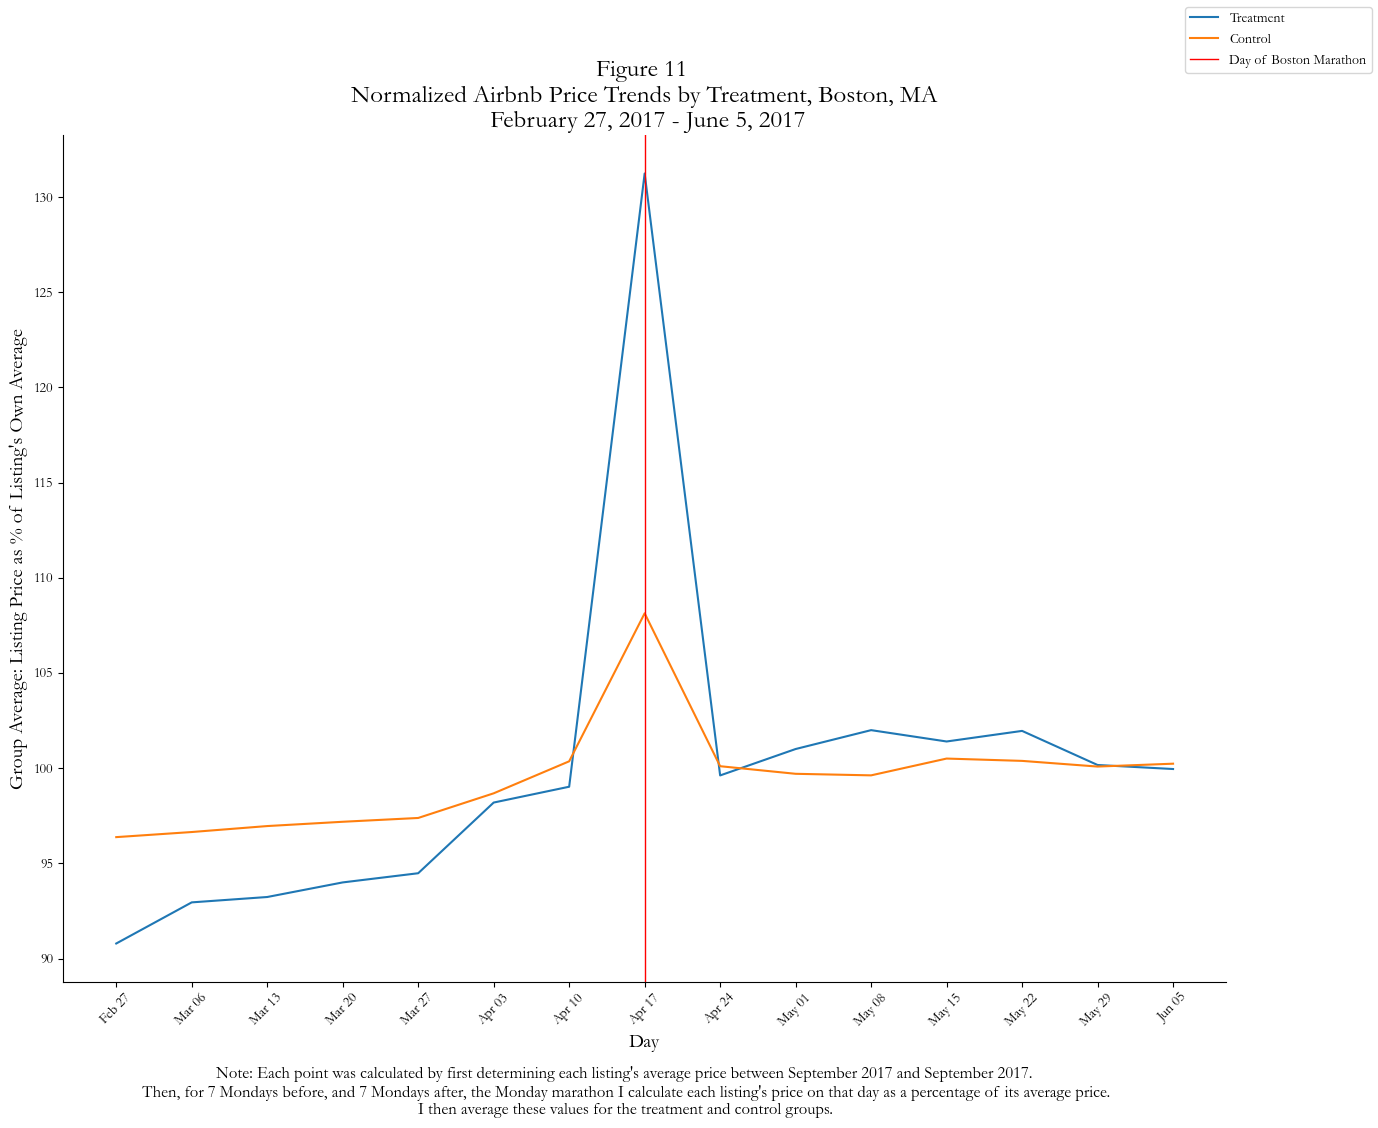

In [927]:
#treatment is listings in close neighbourhoods
treatment = ["Back Bay", "South End", "Beacon Hill", "Chinatown",
            "Fenway", "Downtown", "West End", "Longwood"]
#control is listings in mid-range and far neighbourhoods
control = ["Mission Hill", "North End", "Roxbury",
            "South Boston Waterfront", "Charlestown",
            "South Boston", "Allston", "Jamaica Plain", 
            "East Boston", "Dorchester", "Brighton",
            "Mattapan", "Roslindale", "Harbor Islands",
            "West Roxbury", "Hyde Park"]

#Create dummy variables indicating if a listing is in a treatment or control neighbourhood
CalLisCrime["treatment"] = CalLisCrime[
    "neighbourhood_cleansed"].isin(treatment).astype(int)
CalLisCrime["control"] = CalLisCrime[
    "neighbourhood_cleansed"].isin(control).astype(int)

temp = CalLisCrime.copy()

#Filter to include only days of interest (Mondays before and after marathon)
#plus Monday of marathon
dates = [
    "2017-02-27", "2017-03-06", "2017-03-13", "2017-03-20", "2017-03-27",
    "2017-04-03", "2017-04-10", "2017-04-17", "2017-04-24",
    "2017-05-01", "2017-05-08", "2017-05-15", "2017-05-22", "2017-05-29",
    "2017-06-05"
]
#Convert dates list to datetime
dates = pd.to_datetime(dates)

#Calculate average price for each listing over time
avg_price_time = temp.groupby("id")[["price"]].mean().reset_index()

#Rename columns to avoid confusion
avg_price_time.rename(columns={"price": "avg_price"}, inplace=True)

#Filter temp to include only the dates of interest
temp = temp[temp["date"].isin(dates)]

#Merge with temp
temp = temp.merge(avg_price_time, on="id", how="left")

#Calculate daily price as a percentage of the average price
temp["price share"] = (temp["price"] / temp["avg_price"]) * 100

#Calculate daily average price share for each treatment group
trends_frame = temp.groupby(["treatment", "date"])[
    "price share"].mean().to_frame().reset_index()

#Group by treatment
trends_frame_graph = trends_frame.groupby("treatment")

# Configure figure and axes
fig, ax = plt.subplots(figsize=(15, 11))

# Plot separate lines for treatment = 1 and treatment = 0
ax.plot(trends_frame_graph.get_group(1)["date"], 
        trends_frame_graph.get_group(1)["price share"], 
        label="Treatment")
ax.plot(trends_frame_graph.get_group(0)["date"], 
        trends_frame_graph.get_group(0)["price share"], 
        label="Control")

#Create title
ax.set_title("Figure 11 \n"
"Normalized Airbnb Price Trends by Treatment, Boston, MA"
"\n February 27, 2017 - June 5, 2017", 
fontsize=18)

#Create axis labels
ax.set_xlabel("Day", fontsize = 14)
ax.set_ylabel("Group Average: Listing Price as % of Listing's Own Average", 
              fontsize = 14)

#Set x ticks
ax.set_xticks(dates)
ax.set_xticklabels([date.strftime('%b %d') for date in dates], rotation=45)

#Place vertical line for April 17th
ax.axvline(x=pd.to_datetime("2017-04-17"), color="red", 
        linestyle="-", linewidth=1,
        label="Day of Boston Marathon")

#Place legend in upper right corner
fig.legend(loc="upper right")

#Remove right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#Create note
plt.figtext(0.5, -0.01, "Note: Each point was calculated by first determining each "
"listing's average price between September 2017 and September 2017. \n "
"Then, for 7 Mondays before, and 7 Mondays after, the Monday marathon I calculate "
"each listing's price on that day as a percentage of its average price. \n" 
"I then average these values for the treatment and control groups.", ha="center", fontsize=12)

plt.show()


This figure was constructed to visually inspect if the parallel trends assumption holds. For my context, this means that in the absence of the Boston Marathon, the treatment and control group's listing prices should follow along a similar trend (Angrist & Pischke, 2015). However, this assumption does not appear to hold after visually inspecting Figure 11. Thus, the control variables noted above will be used to help remove bias in my regression estimates between my treatment and control groups.

Treatment listings are from: Back Bay, South End, Beacon Hill, Chinatown, Fenway, Downtown, West End, and Longwood. These are neighbourhoods classified as 'close'.

Control listings are from: Mission Hill, North End, Roxbury, South Boston Waterfront, Charlestown, South Boston, Allston, Jamaica Plain, East Boston, Dorchester, Brighton, Mattapan, Roslindale, Harbor Islands, West Roxbury, and Hyde Park. These are neighbourhoods classified as either 'mid range' or 'far'.


## 7.3. Pre-Treatment Balance Between Treatment and Control Listings

In [928]:
from scipy.stats import ttest_ind

#treatment is listings in close neighbourhoods
treatment = ["Back Bay", "South End", "Beacon Hill", "Chinatown",
            "Fenway", "Downtown", "West End", "Longwood"]
#control is listings in mid-range and far neighbourhoods
control = ["Mission Hill", "North End", "Roxbury",
            "South Boston Waterfront", "Charlestown",
            "South Boston", "Allston", "Jamaica Plain", 
            "East Boston", "Dorchester", "Brighton",
            "Mattapan", "Roslindale", "Harbor Islands",
            "West Roxbury", "Hyde Park"]

#Create a new column for beds per bedroom. If a listing has 0 bedrooms, set beds per bedroom to NaN
CalLisCrime["Beds per Bedroom"] = np.where(CalLisCrime["bedrooms"] == 0, \
      np.nan, CalLisCrime["beds"] / CalLisCrime["bedrooms"])

#Create dummy variables indicating if a listing is in a treatment or control neighbourhood
CalLisCrime["treatment"] = CalLisCrime[
    "neighbourhood_cleansed"].isin(treatment).astype(int)
CalLisCrime["control"] = CalLisCrime[
    "neighbourhood_cleansed"].isin(control).astype(int)

balance_frame = CalLisCrime.copy()

#Create a dataframe with only the columns needed for the balance test
balance_frame = balance_frame[["date", "bathrooms", "bedrooms", "beds",
                              "Superhost", "Entire home/apt", "control",
                              "Private room", "Shared room", 
                              "treatment", "Beds per Bedroom",
                               "host_total_listings_count", "price"]]

#Restrict dataset to April 10th, 2017
balance_frame = balance_frame[balance_frame["date"] == "2017-04-10"]

#Get values for N row
count = balance_frame[["treatment", "control"]].sum().to_frame().T
count["Total"] = count["treatment"] + count["control"]
count.columns = ["Treatment", "Control", "Difference"]

#Calculate the mean of each column for treatment and control
grouped = balance_frame.groupby("treatment")[["price", "bathrooms", "bedrooms",
                                    "beds", "Beds per Bedroom", "Superhost",
                                    "Entire home/apt", "Private room", 
                                    "Shared room", "host_total_listings_count"
                                    ]].mean().T.reset_index()

#Calculate the difference between treatment and control
grouped["difference"] = grouped[0] - grouped[1]

#Create columns
grouped.columns = ["Variable", "Treatment", "Control", "Difference"]

#Create list of variables to test
vars_to_test = ["price", "bathrooms", "bedrooms", "beds", "Beds per Bedroom", 
                "Superhost", "Entire home/apt", "Private room", "Shared room",
                "host_total_listings_count"]

#Create empty list to store p-values
p_values = []

#Loop through vars to test
for var in vars_to_test:
      #Drop NaN values
      treated = balance_frame[balance_frame["treatment"] == 1][var].dropna()
      ctrl = balance_frame[balance_frame["treatment"] == 0][var].dropna()
      #Perform t-test
      stat, p = ttest_ind(treated, ctrl, equal_var=False)
      #Append p-value to list
      p_values.append(p)

#Define significance stars function
#Function will take a value of p and return a string of stars
#based on the value of p
def stars(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.1:
        return "*"
    else:
        return ""

#Create column for p-values
grouped["p-value"] = p_values

#Create column for stars, apply the stars function to the p-value column
grouped["Sig."] = grouped["p-value"].apply(stars)

#Create column for difference, add the stars to the difference column
grouped["Difference"] = grouped[
    "Difference"].round(3).astype(str) + grouped["Sig."]

#Drop p-value and Sig. columns
grouped.drop(columns=["p-value", "Sig."], inplace=True)

#Set vriable as index
grouped.set_index("Variable", inplace=True)

#Merge with count (for N row)
balance_frame = pd.concat([grouped, count])

#Reorder columns
balance_frame.index = ["Price", "Bathrooms", "Bedrooms", "Beds", 
                       "Beds per Bedroom", "Superhost", "Entire home/apt", 
                       "Private room", "Shared room",
                        "host_total_listings_count", "N"]

#Add title 
balance_frame.style.set_caption("Table 5: Balance Test for Treatment and Control "
                                "Neighbourhoods - Boston, MA: April 10th, 2017"
                               )

,Treatment,Control,Difference
Price,151.328865,250.643436,-99.315***
Bathrooms,1.239060,1.194504,0.045***
Bedrooms,1.320954,1.154122,0.167***
Beds,1.652554,1.541311,0.111***
Beds per Bedroom,1.217375,1.212819,0.005
Superhost,0.131591,0.085409,0.046***
Entire home/apt,0.459422,0.801423,-0.342***
Private room,0.516277,0.179359,0.337***
Shared room,0.024301,0.019217,0.005
host_total_listings_count,20.912884,117.918861,-97.006***


Significance stars are as follows: *** p < 0.01, ** p < 0.05, * p < 0.1

This table is intended to check for balance between my treatment and control groups, as imbalance yields section bias in my regression estimates (Angrist & Pischke, 2015). Evidently, Price, Bathrooms, Bedrooms, Beds, Superhost, Entire home/apt, Private room, and the count of host's total listings all have statistically significant differences and will need to be included in my regression as controls (obviously price is not a control, it is the dependent variable).

## 7.4. Difference-in-Differences Regression

I first estimate a simple two period difference-in-differences regression model akin to Angrist & Pischke (2015):

$$
\log(\text{Price}_{it}) = \beta_0 + \beta_1 \text{Treatment}_{i} + \beta_2 \text{MarathonDate}_{t} + \beta_3 \text{Superhost}_{i} \\
+ \beta_4 (\text{Treatment}_{i} \times \text{MarathonDate}_{t}) + \beta_5 (\text{Treatment}_{i} \times \text{MarathonDate}_{t} \times \text{Superhost}_{i}) + \beta_6 X_{it}' + \varepsilon_{it}
$$

Where:
- $ \log(\text{Price}_{it}) $ is the log of Airbnb listing price for listing $i$ on date $t$.
- $ \text{Treatment}_{i} $ is an indicator that equals 1 if listing $i$ is in the treatment group, and 0 if listing $i$ is in the control group.
- $ \text{MarathonDate}_{t} $ is an indicator that equals 1 if day $t$ is April 17, 2017 (Boston Marathon date), and 0 otherwise.
- $ \text{Superhost}_{i} $ is an indicator that equals 1 if listing $i$ is a Superhost, and 0 otherwise.
- $ \text{Treatment}_{i} \times \text{MarathonDate}_{t} $ is an interaction term that captures the causal effect of the marathon on listing price.
- $ \text{Treatment}_{i} \times \text{MarathonDate}_{t} \times \text{Superhost}_{i} $ is a triple interaction term that allows for heterogeneous effects of the marathon on Superhost listings.
- $ X_{it}' $ is a vector of additional control variables for listing $i$ on date $t$.
- $ \varepsilon_{it} $ is the error term.

In [929]:
reg_frame1 = CalLisCrime.copy()

reg_frame1 = reg_frame1.dropna(subset=["id", "price"])

#Filter to only inlude April 10th to 17th, 2017
reg_frame1 = reg_frame1[(reg_frame1["date"] >= "2017-04-01") &
                        (reg_frame1["date"] <= "2017-04-30")]

#Drop listings with Nan in Beds per Bedroom or bathrooms
reg_frame1 = reg_frame1[reg_frame1["bathrooms"].notna()]
reg_frame1 = reg_frame1[reg_frame1["Beds per Bedroom"].notna()]

#Create a dummy if listing is on the day of the Boston Marathon
reg_frame1["Marathon Period"] = (reg_frame1["date"] == "2017-04-17").astype(int)

#Create log price variable
reg_frame1["Log(Price)"] = np.log(reg_frame1["price"])

#Create interaction term between treatment and marathon date
reg_frame1["Treatment*Marathon Period"] = reg_frame1["treatment"] * \
                                       reg_frame1["Marathon Period"]

#Create a triple interaction with treatment, marathon date, and superhost
reg_frame1["Treatment*Marathon Period*Superhost"] = reg_frame1["treatment"]* \
    reg_frame1["Marathon Period"] * reg_frame1["Superhost"]

In [930]:
population_by_neighbourhood = {
    "Allston": 19363,
    "Back Bay": 18176,
    "Beacon Hill": 9751,
    "Brighton": 51785,
    "Charlestown": 18901,
    "Dorchester": 125947,
    "Downtown": 17581,
    "East Boston": 46655,
    "Fenway": 32598,
    "Harbor Islands": 322,
    "Hyde Park": 37094,
    "Jamaica Plain": 39314,
    "Longwood": 5389,
    "Mattapan": 25586,
    "Mission Hill": 17406,
    "North End": 9271,
    "Roslindale": 29206,
    "Roxbury": 52944,
    "South Boston": 36212,
    "South Boston Waterfront": 3443,
    "South End": 32040,
    "West End": 6173,
    "West Roxbury": 33930
}

boston_neighborhoods_crime = boston_neighbourhoods.copy()

#Create a new column for population
boston_neighborhoods_crime[
    "population"] = boston_neighborhoods_crime["neighborhood"].map(
    population_by_neighbourhood)

#Drop NaN values
boston_neighborhoods_crime.dropna(subset=["population"], inplace=True)

crime_nei = crime.copy()

#Prep location of crime
crime_nei["Location"] = crime_nei["Location"].str.strip("()")
crime_nei["Location"] = crime_nei["Location"].str.split(", ")
crime_nei["Location"] = crime_nei["Location"].apply(lambda x: tuple(x))
crime_nei["Location"] = crime_nei["Location"].apply(Point)
crime_nei["Location"] = crime_nei["Location"].apply(lambda p: Point(p.y, p.x))

#Create date column
crime_nei["date"] = pd.to_datetime(crime_nei["OCCURRED_ON_DATE"]).dt.date

#Convert to GeoDataFrame
crime_nei = gpd.GeoDataFrame(crime_nei, geometry="Location")
crime_nei = crime_nei.set_crs(epsg=4326) 

#Match neihbourhoods with crime data
crime_nei = gpd.sjoin(crime_nei, boston_neighborhoods_crime,
                       how="right", predicate="within")

crime_nei.dropna(subset=["neighborhood"], inplace=True)

#Count daily crime incidents per neighbourhood
crime_nei = crime_nei.groupby(["date", 
    "neighborhood"])["index_left"].count().reset_index()

crime_nei.rename(columns={"index_left": "crime_count"}, inplace=True)

#Convert date to datetime
crime_nei["date"] = pd.to_datetime(crime_nei["date"])

#Add population column
crime_nei["Population"] = crime_nei[
    "neighborhood"].map(population_by_neighbourhood)

#Add crime per capita column
crime_nei["Daily Crime Per Capita"] = crime_nei[
    "crime_count"] / crime_nei["Population"]

reg_frame1.rename(columns={"neighbourhood_cleansed": "neighborhood"}, 
                  inplace=True)

#Merge with reg_frame1
reg_frame1 = reg_frame1.merge(crime_nei, on=["date", "neighborhood"], 
                              how="left")

reg_frame1["Daily Crime Per Capita"] = reg_frame1[
    "Daily Crime Per Capita"].fillna(0)

In [931]:
Y = reg_frame1["Log(Price)"]

X1 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period"]]
X1 = sm.add_constant(X1)

X2 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period", "Superhost"]]
X2 = sm.add_constant(X2)

X3 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period", 
                "Superhost", "Treatment*Marathon Period*Superhost"]]
X3 = sm.add_constant(X3)

X4 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period", 
                "Superhost", "Treatment*Marathon Period*Superhost", "Beds per Bedroom"]]
X4 = sm.add_constant(X4)

X5 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period", 
                "Superhost", "Treatment*Marathon Period*Superhost", 
                "Beds per Bedroom", "bathrooms"]]
X5 = sm.add_constant(X5)

X6 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period",
                "Superhost", "Treatment*Marathon Period*Superhost", 
                "Beds per Bedroom", "bathrooms", "Daily Crime Per Capita"]]
X6 = sm.add_constant(X6)

#Entire home/apt is reference
X7 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period",
                "Superhost", "Treatment*Marathon Period*Superhost", 
                "Beds per Bedroom", "bathrooms", "Daily Crime Per Capita",
                "Private room", "Shared room"]]
X7 = sm.add_constant(X7)

#Home is reference
#Drop Villa due to there only being 2 observations
X8 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period",
                "Superhost", "Treatment*Marathon Period*Superhost", 
                "Beds per Bedroom", "bathrooms", "Daily Crime Per Capita",
                "Private room", "Shared room", 'Apartment', 'Bed & Breakfast', 
                'Boat', 
                'Condominium', 'Entire Floor', 
                'Loft', 'Townhouse']]
X8 = sm.add_constant(X8)

#Cluster se's at the listing level
model1 = sm.OLS(Y, X1).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model2 = sm.OLS(Y, X2).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model3 = sm.OLS(Y, X3).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model4 = sm.OLS(Y, X4).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model5 = sm.OLS(Y, X5).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model6 = sm.OLS(Y, X6).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model7 = sm.OLS(Y, X7).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model8 = sm.OLS(Y, X8).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})

stargazer = Stargazer([model1, model2, model3, model4, model5, model6, model7, model8])

stargazer.covariate_order(["treatment", "Marathon Period",
                            "Treatment*Marathon Period",
                            "Superhost",
                            "Treatment*Marathon Period*Superhost",
                            "Beds per Bedroom", "bathrooms", 
                            "Daily Crime Per Capita",
                            "const"])

#Rename regressors for table
stargazer.rename_covariates({
    "treatment": "Treatment Listing",
    "Marathon Period": "Boston Marathon Day",
    "Treatment*Marathon Period": "Treatment Listing X Boston Marathon Day",
    "Treatment*Marathon Period*Superhost": 
    "Treatment Listing X Marathon Day X Superhost",
    "bathrooms": "Number of Bathrooms",
    "const": "Constant"
})

stargazer.add_line("Room Type Controls", 
                   ["No", "No", "No", "No", "No", "No", "Yes", "Yes"])
stargazer.add_line("Property Type Controls", 
                   ["No", "No", "No", "No", "No", "No", "No", "Yes"])

#Create a title
stargazer.title("Table 6: Difference-in-Differences Regression Estimates")

#Create a note
stargazer.add_custom_notes(["Standard errors are clustered at the listing level. \
                            The dependent variable is the natural log of listing price. "
                            "Daily Crime Per Capita is assigned to a listing-day based on the"
                            " per capita crime in that listing's neighbourhood for that day."
                            " The sample \
                            includes listings with observations between April 1st and 30th, 2017. " \
                            "The Marathon Day is April 17th, 2017 " \
                            "Listings are assigned to treatment based on their neighbourhood. \
                            Treatment neighbourhoods include: Back Bay, Beacon Hill, Fenway, "
                            "Downtown, South End, Chinatown, North End, West End,"
                            " Leather District, and Bay Village. "
                            "These are neighbourhoods classified as 'close' to the "
                            "Boston Marathon finish line. Control neighbourhoods include: "
                            "Allston, Mission Hill, Charlestown, Brighton, East Boston, "
                            "Hyde Park, Jamaica Plain, Roslindale, Dorchester, West Roxbury, "
                            "Mattapan, South Boston Waterfront, South Boston, Longwood Medical "
                            "Area, and Roxbury. These are neighbourhoods classified as either 'mid range' "
                            "or 'far'."])
                           

html_output = stargazer.render_html()

from IPython.display import display, HTML
display(HTML(html_output))

My preferred regression is specification 8.

Note, coefficient percentage interpretations were calculated by taking (e^β−1)×100 (Angrist and Pischke 2015, 93-94).

The coefficient on Treatment Listing X Boston Marathon Day indicates that, after controlling for property type, room type, the daily number of crimes, the number of bathrooms, the number of beds per bedroom, and Superhost status, Airbnb listings in the treatment group had approximately 16.9% higher listing prices on the day of the Boston Marathon relative to listings in the control group. This implies a significant price surge in areas close to the marathon finish line, which is consistent with my hypothesis that increased demand during the event led to higher listing prices. Furthermore, this coefficient is statistically significant at the 1% level.

Furthermore, the coefficient on Treatment Listing X Marathon Day X Superhost indicates that, after controlling for the variables listed above, Superhost listings in the treatment group had prices that were approximately 32.2% higher on the day of the Boston Marathon compared to non-Superhost listings in the control group. This suggests that Superhost differ in their 'marathon pricing strategy'. This coefficient is also statistically significant at the 1% level.

## 7.4.1. Placebo Test

In [932]:
reg_frame2 = CalLisCrime.copy()

reg_frame2 = CalLisCrime.dropna(subset=["id", "price"]).copy()

#Filter to only inlude April 3rd and April 10th
reg_frame2 = reg_frame2[(reg_frame2["date"] >= "2017-03-01") &
                         (reg_frame2["date"] <= "2017-03-31")]

#Drop listings with Nan in Beds per Bedroom or bathrooms
reg_frame2 = reg_frame2[reg_frame2["bathrooms"].notna()]
reg_frame2 = reg_frame2[reg_frame2["Beds per Bedroom"].notna()]

#Create a dummy if listing is on placebo period
reg_frame2["Placebo Period"] = (reg_frame2["date"] == "2017-03-13").astype(int)

#Create log price variable
reg_frame2["Log(Price)"] = np.log(reg_frame2["price"])

#Create interaction term between treatment and marathon date
reg_frame2["Treatment*Placebo Period"] = reg_frame2["treatment"] * \
                                       reg_frame2["Placebo Period"]

reg_frame2["Treatment*Placebo Period*Superhost"] = reg_frame2["treatment"]* \
    reg_frame2["Placebo Period"] * reg_frame2["Superhost"]


In [933]:
population_by_neighbourhood = {
    "Allston": 19363,
    "Back Bay": 18176,
    "Beacon Hill": 9751,
    "Brighton": 51785,
    "Charlestown": 18901,
    "Dorchester": 125947,
    "Downtown": 17581,
    "East Boston": 46655,
    "Fenway": 32598,
    "Harbor Islands": 322,
    "Hyde Park": 37094,
    "Jamaica Plain": 39314,
    "Longwood": 5389,
    "Mattapan": 25586,
    "Mission Hill": 17406,
    "North End": 9271,
    "Roslindale": 29206,
    "Roxbury": 52944,
    "South Boston": 36212,
    "South Boston Waterfront": 3443,
    "South End": 32040,
    "West End": 6173,
    "West Roxbury": 33930
}

boston_neighborhoods_crime = boston_neighbourhoods.copy()

#Create a new column for population
boston_neighborhoods_crime["population"] = boston_neighborhoods_crime[
    "neighborhood"].map(
    population_by_neighbourhood)

#Drop NaN values
boston_neighborhoods_crime.dropna(subset=["population"], inplace=True)

crime_nei = crime.copy()

#Prep location of crime
crime_nei["Location"] = crime_nei["Location"].str.strip("()")
crime_nei["Location"] = crime_nei["Location"].str.split(", ")
crime_nei["Location"] = crime_nei["Location"].apply(lambda x: tuple(x))
crime_nei["Location"] = crime_nei["Location"].apply(Point)
crime_nei["Location"] = crime_nei["Location"].apply(lambda p: Point(p.y, p.x))

#Create date column
crime_nei["date"] = pd.to_datetime(crime_nei["OCCURRED_ON_DATE"]).dt.date

#Convert to GeoDataFrame
crime_nei = gpd.GeoDataFrame(crime_nei, geometry="Location")
crime_nei = crime_nei.set_crs(epsg=4326) 

#Match neihbourhoods with crime data
crime_nei = gpd.sjoin(crime_nei, boston_neighborhoods_crime,
                       how="right", predicate="within")

crime_nei.dropna(subset=["neighborhood"], inplace=True)

#Count daily crime incidents per neighbourhood
crime_nei = crime_nei.groupby(["date", "neighborhood"])[
    "index_left"].count().reset_index()

crime_nei.rename(columns={"index_left": "crime_count"}, inplace=True)

#Convert date to datetime
crime_nei["date"] = pd.to_datetime(crime_nei["date"])

#Add population column
crime_nei["Population"] = crime_nei[
    "neighborhood"].map(population_by_neighbourhood)

#Add crime per capita column
crime_nei["Daily Crime Per Capita"] = crime_nei[
    "crime_count"] / crime_nei["Population"]

reg_frame2.rename(columns={"neighbourhood_cleansed": 
                           "neighborhood"}, inplace=True)

#Merge with reg_frame2
reg_frame2 = reg_frame2.merge(crime_nei, on=["date", "neighborhood"], 
                              how="left")

reg_frame2["Daily Crime Per Capita"] = reg_frame2[
    "Daily Crime Per Capita"].fillna(0)

In [934]:
Y = reg_frame2["Log(Price)"]

X1 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period"]]
X1 = sm.add_constant(X1)

X2 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period", "Superhost"]]
X2 = sm.add_constant(X2)

X3 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period", 
                "Superhost", "Beds per Bedroom"]]
X3 = sm.add_constant(X3)

X4 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period", 
                "Superhost", 
                "Beds per Bedroom", "bathrooms"]]
X4 = sm.add_constant(X4)

X5 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period",
                "Superhost", 
                "Beds per Bedroom", "bathrooms", "Daily Crime Per Capita"]]
X5 = sm.add_constant(X5)

#Entire home/apt is reference
X6 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period",
                "Superhost", 
                "Beds per Bedroom", "bathrooms", "Daily Crime Per Capita",
                "Private room", "Shared room"]]
X6 = sm.add_constant(X6)

#Home is reference
#Drop Villa due to there only being 2 observations
X7 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period",
                "Superhost", 
                "Beds per Bedroom", "bathrooms", "Daily Crime Per Capita",
                "Private room", "Shared room", 'Apartment', 'Bed & Breakfast', 
                'Boat', 
                'Condominium', 'Entire Floor', 
                'Loft', 'Townhouse']]
X7 = sm.add_constant(X7)

model1 = sm.OLS(Y, X1).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model2 = sm.OLS(Y, X2).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model3 = sm.OLS(Y, X3).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model4 = sm.OLS(Y, X4).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model5 = sm.OLS(Y, X5).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model6 = sm.OLS(Y, X6).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model7 = sm.OLS(Y, X7).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})

stargazer = Stargazer([model1, model2, model3, model4, model5, model6, model7])

stargazer.add_line("Room Type Controls", 
                   ["No", "No", "No", "No", "No", "Yes", "Yes"])
stargazer.add_line("Property Type Controls", 
                   ["No", "No", "No", "No", "No", "No", "Yes"])

stargazer.covariate_order(["treatment", "Placebo Period",
                            "Treatment*Placebo Period",
                            "Superhost",
                            "Beds per Bedroom", "bathrooms", 
                            "Daily Crime Per Capita",
                            "const"])

#Rename regressors for table
stargazer.rename_covariates({
    "treatment": "Treatment Listing",
    "Placebo Period": "Placebo Period",
    "Treatment*Placebo Period": "Treatment Listing X Placebo Period",
    "bathrooms": "Number of Bathrooms",
    "const": "Constant"
})

#Create a title
stargazer.title("Table 7: Difference-in-Differences Placebo Regression Estimates")

#Create a note
stargazer.add_custom_notes(["Standard errors are clustered at the listing level. \
                            The dependent variable is the natural log of listing price. The sample \
                            includes listings with observations on March 1st and 31st, 2017. \
                            Monday March 13th, 2017 is the placebo period. \
                            Listings are assigned to treatment based on their neighbourhood. \
                            Treatment neighbourhoods include: Back Bay, Beacon Hill, Fenway, "
                            "Downtown, South End, Chinatown, North End, West End,"
                            " Leather District, and Bay Village. "
                            "These are neighbourhoods classified as 'close' to the "
                            "Boston Marathon finish line. Control neighbourhoods include: "
                            "Allston, Mission Hill, Charlestown, Brighton, East Boston, "
                            "Hyde Park, Jamaica Plain, Roslindale, Dorchester, West Roxbury, "
                            "Mattapan, South Boston Waterfront, South Boston, Longwood Medical "
                            "Area, and Roxbury. These are neighbourhoods classified as either 'mid range' "
                            "or 'far'."])
                           

html_output = stargazer.render_html()

from IPython.display import display, HTML
display(HTML(html_output))

One test for the validity of a difference-in-differences regression is a placebo test (Cunningham, 2021).

In specification 7, the coefficient on Treatment Listing X Placebo Period is statistically significant at the 1% level but is economically insignificant and negative in magnitude.
The fact that the coefficient is small and negative still suggests a Boston Marathon price effect.

## 7.5. Difference-in-Differences Regression With Fixed Effects

Lastly, I estimate a panel difference-in-differences regression model akin to Angrist and Pischke (2015):

$$
\log(\text{Price}_{it}) = \beta_0 + \beta_1 (\text{Treatment}_i \times \text{MarathonDay}_t) + \\ \beta_2 (\text{Treatment}_i \times \text{MarathonDay}_t \times \text{Superhost}_i)
+ \sum_{d} \beta_{3d} (\text{Treatment}_i \times \text{DayOfWeek}_{dt}) 
+ \\ \sum_{t} \beta_{4t} \text{DailyFE}_t + \sum_{i} \beta_{5i} \text{ListingFE}_i + \varepsilon_{it}
$$

### **Where:**
- $ \log(\text{Price}_{it}) $ is the log of Airbnb listing price for listing $i$ on date $t$.
- $ \text{Treatment}_{i} $ is an indicator that equals 1 if listing $i$ is in the treatment group, and 0 otherwise.
- $ \text{MarathonDay}_{t} $ is an indicator that equals 1 if day $t$ is April 17, 2017, and 0 otherwise.
- $ \text{Superhost}_{i} $ is an indicator that equals 1 if listing $i$ is a Superhost, and 0 otherwise.
- $ \text{Treatment}_{i} \times \text{MarathonDay}_{t} $ is an interaction term that captures the causal effect of the Boston Marathon on listing price.
- $ \text{Treatment}_{i} \times \text{MarathonDay}_{t} \times \text{Superhost}_{i} $ is a triple interaction term that allows for heterogeneous effects of the marathon on Superhost listings.
- $ \sum_d \beta_{4d} (\text{Treatment}_i \times \text{DayOfWeek}_{dt}) $ are interaction fixed effects allowing treated listings to have different day-of-week patterns than control listings.
- $ \sum_t \beta_{5t} \text{DailyFE}_t $ are Daily Fixed Effects which control for shocks affecting all listings on the same day.
- $ \sum_i \beta_{6i} \text{ListingFE}_i $ are Listing Fixed Effects which control for listing characteristics that do not change over time.
- $ \varepsilon_{it} $ is the error term.


In [935]:
#Documentation: 
#https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.html
from linearmodels.panel import PanelOLS

panel_frame = CalLisCrime.copy()

#Filter to include only April 1st to 30th, 2017
panel_frame = panel_frame[(panel_frame["date"] >= "2017-04-01") & 
                          (panel_frame["date"] <= "2017-04-30")]

#Create dummy if listing falls on marathon day, April 17th, 2017
panel_frame["MarathonPeriod"] = (panel_frame[
    "date"] == "2017-04-17").astype(int)

#Create log price variable
panel_frame["Log_Price"] = np.log(panel_frame["price"])

#Create interaction term between treatment and marathon date
panel_frame["Treatment_MarathonPeriod"] = panel_frame["treatment"] * \
                                       panel_frame["MarathonPeriod"]

#Create triple interaction term between treatment, marathon date, and superhost
panel_frame["Treatment_MarathonPeriod_Superhost"] = panel_frame["treatment"] * \
    panel_frame["MarathonPeriod"] * panel_frame["Superhost"]

#Create string for day of week
panel_frame["Day of Week"] = panel_frame["date"].dt.day_name()

#Friday is reference category
#Create dummy variables for day of week
dow_dummies = pd.get_dummies(panel_frame["Day of Week"], prefix="DayofWeek", 
                             drop_first=True)
panel_frame = pd.concat([panel_frame, dow_dummies], axis=1)

#Create interaction terms for each day of week with treatment
for column in dow_dummies.columns:
    panel_frame[f'Treatment_{column}'] = panel_frame[
        "treatment"] * panel_frame[column]

#Create string for interaction terms for compatability with PanelOLS
dow_interaction_terms = " + ".join([
    f"Treatment_{col}" for col in dow_dummies.columns])

#Keep id as a column for clustering
panel_frame["id_col"] = panel_frame["id"]  

# Set index to id and date for PanelOLS model
panel_frame = panel_frame.set_index(['id', 'date'])

#Drop NaN values in Log_Price and Treatment_MarathonPeriod
panel_frame = panel_frame.dropna(subset=["Log_Price", "Treatment_MarathonPeriod"])

#Run PanelOLS model from a formula
#Entity Effects and Time Effects are defined by the index
#Entity Effects correspond to the id variable
#Time Effects correspond to the date variable

#Model 1
#Only listing FE
model1 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + EntityEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])

#Model 2
#Only time FE
model2 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + TimeEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])

#Model 3
#Only treatment X day of week FE
model3 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + " + dow_interaction_terms,
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])

#Model 4
#Listing, time, and treatment X day of week FE
model4 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + " + 
    dow_interaction_terms + " + EntityEffects + TimeEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])

#Model 5
#Listing, time, treatment X day of week FE and triple interaction
model5 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + Treatment_MarathonPeriod_Superhost + " +
    dow_interaction_terms + " + EntityEffects + TimeEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])

#Create table for model

stargazer = Stargazer([model1, model2, model3, model4, model5])

#Add row to table to indicate which effects are active in each column
stargazer.add_line("Listing Fixed Effects", 
                   ["Yes", "No", "No", "Yes", "Yes"])
stargazer.add_line("Daily Fixed Effects", 
                   ["No", "Yes", "No", "Yes", "Yes"])
stargazer.add_line("Treatment X Day of Week Fixed Effects",
                     ["No", "No", "Yes", "Yes", "Yes"])

#Reorder rows
stargazer.covariate_order(["Treatment_MarathonPeriod",
                            "Treatment_MarathonPeriod_Superhost"])

#Rename interaction term
stargazer.rename_covariates({"Treatment_MarathonPeriod": 
                             "Treatment Listing X Marathon Period",
                             "Treatment_MarathonPeriod_Superhost": 
                             "Treatment Listing X Marathon Period X Superhost"
                            })

#Create a title
stargazer.title("Table 8: Difference-in-Differences With Fixed Effects "
"Regression Estimates")

#Create a note
stargazer.add_custom_notes(["Standard errors are clustered at the listing level. \
The dependent variable is the natural log of listing price. "
"Marathon Period equals 1 for listings on April 17th, 2017, the day "
"of the Boston Marathon. The sample \
includes listings with observations between April 1st and 30th, 2017. \
Listings are assigned to treatment based on their neighbourhood's " \
"distance to the Boston Marathon finish line. \
Treatment neighbourhoods include: Back Bay, "
"South End, Beacon Hill, Chinatown, Fenway, Downtown, West End, "
"and Longwood. These are neighbourhoods classified as 'Close' to "
"the Boston Marathon finish line. Control neighbourhoods include: "
"Mission Hill, North End, Roxbury, South Boston Waterfront, Charlestown, "
"South Boston, Allston, Jamaica Plain, East Boston, Dorchester, "
"Brighton, Mattapan, Roslindale, "
"Harbor Islands, West Roxbury, and Hyde Park. These are "
"neighbourhoods classified as either 'Mid Range' or 'Far' from"
" the Boston Marathon finish line."])
                           
html_output = stargazer.render_html()

from IPython.display import display, HTML
display(HTML(html_output))

My preferred regression is specification 5.

Note, the superhost dummy is captured by the fixed effects and is thus not included in the model. Similarly, day of week fixed effects are excluded from the model as they are absorbed by daily fixed effects.

The coefficient on Treatment Listing X Marathon Period indicates that after controlling for listing and daily fixed effects, and fixed effects of the interaction between treatment and day of week, Airbnb listings in the treatment group had approximately 16.9% higher listing prices on the day of the Boston Marathon relative to listings in the control group. This coefficient is also statistically significant at the 1% level. This finding is consistent with my hypothesis that increased demand during the event led to higher listing prices.

Furthermore, the coefficient on Treatment Listing X Marathon Period X Superhost indicates that, after controlling listing and daily fixed effects, Superhost listings in the treatment group had prices that were approximately 11.4% higher on the day of the Boston Marathon compared to non-Superhost listings in the control group. This coefficient is also statistically significant at the 5% level. This supports claims that Superhosts vary in their 'marathon pricing strategy'. 


## 7.5.1. Placebo Test

In [936]:
#Documentation: 
#https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.html
from linearmodels.panel import PanelOLS

placebo_frame = CalLisCrime.copy()

#Filter to include only March 1st to 31st, 2017
placebo_frame = placebo_frame[(placebo_frame["date"] >= "2017-03-01") & 
                          (placebo_frame["date"] <= "2017-03-31")]

#Create dummy if listing falls on placebo date, March 13th, 2017
placebo_frame["PlaceboPeriod"] = (placebo_frame[
    "date"] == "2017-03-13").astype(int)

#Create log price variable
placebo_frame["Log_Price"] = np.log(placebo_frame["price"])

#Create interaction term between treatment and marathon date
placebo_frame["Treatment_PlaceboPeriod"] = placebo_frame["treatment"] * \
                                       placebo_frame["PlaceboPeriod"]

#Create string for day of week
placebo_frame["Day of Week"] = placebo_frame["date"].dt.day_name()

#Friday is reference category
#Create dummy variables for day of week
dow_dummies = pd.get_dummies(placebo_frame["Day of Week"], prefix="DayofWeek", 
                             drop_first=True)
placebo_frame = pd.concat([placebo_frame, dow_dummies], axis=1)

#Create interaction terms for each day of week with treatment
for column in dow_dummies.columns:
    placebo_frame[f'Treatment_{column}'] = placebo_frame[
        "treatment"] * placebo_frame[column]

#Create string for interaction terms for compatability with PanelOLS
dow_interaction_terms = " + ".join([f"Treatment_{col}" for col in dow_dummies.columns])

#Keep id as a column for clustering
placebo_frame["id_col"] = placebo_frame["id"]  

# Set index to id and date for PanelOLS model
placebo_frame = placebo_frame.set_index(['id', 'date'])

#Drop NaN values in Log_Price and Treatment_PlaceboPeriod
placebo_frame = placebo_frame.dropna(subset=[
    "Log_Price", "Treatment_PlaceboPeriod"])

#Run PanelOLS model from a formula
#Entity Effects and Time Effects are defined by the index
#Entity Effects correspond to the id variable
#Time Effects correspond to the date variable

#Model 1
#Only listing FE
model6 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_PlaceboPeriod + EntityEffects",
    data=placebo_frame
).fit(cov_type="clustered", clusters=placebo_frame["id_col"])

#Model 2
#Only time FE
model7 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_PlaceboPeriod + TimeEffects",
    data=placebo_frame
).fit(cov_type="clustered", clusters=placebo_frame["id_col"])

#Model 3
#Only treatment X day of week FE
model8 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_PlaceboPeriod + " + dow_interaction_terms,
    data=placebo_frame
).fit(cov_type="clustered", clusters=placebo_frame["id_col"])

#Model 4
#Listing, time, and treatment X day of week FE
model9 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_PlaceboPeriod + " + 
    dow_interaction_terms + " + EntityEffects + TimeEffects",
    data=placebo_frame
).fit(cov_type="clustered", clusters=placebo_frame["id_col"])

#Create table for model

stargazer = Stargazer([model6, model7, model8, model9])

#Add row to table to indicate which effects are active in each column
stargazer.add_line("Listing Fixed Effects", 
                   ["Yes", "No", "No", "Yes"])
stargazer.add_line("Daily Fixed Effects", 
                   ["No", "Yes", "No", "Yes"])
stargazer.add_line("Treatment X Day of Week Fixed Effects",
                     ["No", "No", "Yes", "Yes"])

#Reorder rows
stargazer.covariate_order(["Treatment_PlaceboPeriod"])

#Rename interaction term
stargazer.rename_covariates({"Treatment_PlaceboPeriod": 
                             "Treatment Listing X Placebo Period",
                            })

#Create a title
stargazer.title("Table 9: Placebo"
" Difference-in-Differences With Fixed Effects Regression Estimates")

#Create a note
stargazer.add_custom_notes(["Standard errors are clustered at the listing level. \
The dependent variable is the natural log of listing price. "
"Placebo Period equals 1 for listings on Monday March 13th, 2017. The sample \
includes listings with observations between March 1st and 31st, 2017. \
Listings are assigned to treatment based on their neighbourhood's " \
"distance to the Boston Marathon finish line. \
Treatment neighbourhoods include: Back Bay, "
"South End, Beacon Hill, Chinatown, Fenway, Downtown, West End, "
"and Longwood. These are neighbourhoods classified as 'Close' to "
"the Boston Marathon finish line. Control neighbourhoods include: "
"Mission Hill, North End, Roxbury, South Boston Waterfront, Charlestown, "
"South Boston, Allston, Jamaica Plain, East Boston, Dorchester, "
"Brighton, Mattapan, Roslindale, "
"Harbor Islands, West Roxbury, and Hyde Park. These are "
"neighbourhoods classified as either 'Mid Range' or 'Far' from"
" the Boston Marathon finish line."])
                           
html_output = stargazer.render_html()

from IPython.display import display, HTML
display(HTML(html_output))

In specification 4, we can see that the coefficient on Treatment Listing X Placebo Period is still statistically significant at the 1% level. However, statistical significance is not economic significance. We can also see that the coefficient is very small in magnitude and is also negative. These findings still ultimately suggest a Boston Marathon price effect.

# Final Project

# 8. Web Scraping

## 8.1. Potential Data to Scrape

My paper examines the effect of the Boston Marathon on the Airbnb market. However, maybe there were other events happening on the day of the marathon. Could events aside from the marathon, that happen to occur on the same day as the marathon, also be bringing tourists to Boston? If so, the estimated effect of the Boston Marathon on Airbnb listing prices may be overstated. 

From this, I scrape The Boston Calendar's list of things to do in Boston on both Monday, April 10th, 2017, and Monday April 17th, 2017, which is the day of the Boston Marathon. The link to the webpage is: https://www.thebostoncalendar.com/events?date=2017-04-28&day=17&month=4&year=2017

The webpage contains a list of names and the location of events occurring in Boston on a select day.

The scraped data will not be added to my original dataset as the unit of observation is not a listing-date, but rather an event occurring at a single point in time. My original dataset is of a panel structure, but the structure of the scraped data will be pooled cross sectional.

I will take the scraped list of events and geo locate the exact location of the venue where each event was held. From this, I map events per capita onto Boston neighbourhoods. This will allow me to see if there was a significant change in both the number and location of events between the day of the Boston Marathon and exactly a week before the marathon. If it happens that there is no significant change, this will then help me argue that the Boston Marathon truly was the main driver behind the Airbnb price surge.

Lastly, this data must be scraped because there are around 80 events list listed per day, making it too time consuming to input manually. Also, the list is not in a table that is easily downloadable. Further, because I need to scrape event lists for multiple days, this time aspect means that scraping is easier over manually collecting the data for each day.

## 8.2. Potential Challenges

First, the location of each event is just the name of the venue where it was held. To map this data, I need to determine the exact latitude and longitude of the venue. Second, the list of events may not be comprehensive. Unfortunately, it is challenging to find a list of events that occurred in a specific city on a specific day in the past. Another challenge has to do with the fact that I want to scrape event lists over multiple days. To address this, I loop through the urls for each day to scrape each day's webpage.

## 8.3. Scraping Data from a Website

In [937]:
import requests
from bs4 import BeautifulSoup

#Create list of urls to scrape
urls = ["https://www.thebostoncalendar.com/events?date=2017-04-28&day=10&month=4&year=2017",
       "https://www.thebostoncalendar.com/events?date=2017-04-28&day=17&month=4&year=2017"]

#Create empty dataframe to store event data
event_location = pd.DataFrame(columns=["Date", "Event", "Location"])


I first begin by importing the libraries required for web scraping, create a list of the urls which I will scrape, and create an empty dataframe.

In [ ]:
day = 10

#Loop through each url
for url in urls:
    #Get the content of the page
    response = requests.get(url)
    #Structure the content
    soup_object = BeautifulSoup(response.content)
    #Find all the events
    table = soup_object.find_all("li", class_="event")
    #Loop through each event
    for event in table:
        #Store event date
        event_date = "2017-04-" + str(day)
        #Store event name
        event_name = event.find("h3").text.strip()
        #Store event location
        location = event.find("p", class_="location").text.strip()
        #Add event information to event_location dataframe
        event_location.loc[len(event_location)] = [
            event_date, event_name, location]
    day = day + 7

,Date,Event,Location
0,2017-04-10,Shop and Savasana for a Cause,Reebok Back Bay Showroom
1,2017-04-10,New Wave Gives Back: One Boston Day 2017,New Wave Boston Real Estate
2,2017-04-10,SWEET Bakery Launches New Coffee Menu with Fr...,Sweet Bakery
3,2017-04-10,Droidcon Boston,Calderwood Theater
4,2017-04-10,Collaboration in Clay and Metal,Clever Hand gallery
...,...,...,...
135,2017-04-17,Band of Friends at Passim,Club Passim
136,2017-04-17,North East Regional Button Show,Double Tree Hilton
137,2017-04-17,Shit-faced Shakespeare,The Rockwell
138,2017-04-17,The Office Trivia @DIG,DIG Kendall square


I loop through each url starting with April 10th, 2017. For each url I use requests.get() to store the raw content of each web page. I then structure this raw content using BeautifulSoup(). Then, I find that each event's information (which are stored in "li" items of class "event") using .find_all(). After, I loop through each event and store their date as a string. I then find and store the "h3" item, which is the name of the event. Then, I find and store each "p" item of class "location", which is the event's location. Lastly, I add these stored values to the event_location dataframe and loop to the next url.  

In [939]:
#Drop sponsored events which are in 2025
event_location = event_location[~event_location["Event"].isin([
    "March Mania Madness Game Watches at Sam Adams!",
    "Trillium VIP Brewery/Distillery Tour & Tasting- Transportation from Boston Included- 15% Off!",
    "Affordable Spanish Classes in Boston (in-person and online courses) | BASE"
])]

In [ ]:
#Idea sourced from: 
#https://medium.com/@hazallgultekin/convert-address-to-latitude-longitude-using-python-21844da3d032

import geopy
from geopy.geocoders import Nominatim

event_location = event_location.copy()

# Add empty columns
event_location["longitude"] = None
event_location["latitude"] = None

loc = Nominatim(user_agent="Geopy Library")

#Loop through each row in event_location
for index, row in event_location.iterrows():
    #Extract location from the row
    location = row["Location"]
    #Use geopy to get the latitude and longitude
    getloc = loc.geocode(location, timeout=10)
    if getloc:  
        event_location.at[index, "longitude"] = getloc.longitude
        event_location.at[index, "latitude"] = getloc.latitude
    else:
        continue

event_location_points = event_location.copy()

,Date,Event,Location,longitude,latitude
0,2017-04-10,Shop and Savasana for a Cause,Reebok Back Bay Showroom,None,None
1,2017-04-10,New Wave Gives Back: One Boston Day 2017,New Wave Boston Real Estate,None,None
2,2017-04-10,SWEET Bakery Launches New Coffee Menu with Fr...,Sweet Bakery,0.005882,51.546577
3,2017-04-10,Droidcon Boston,Calderwood Theater,None,None
4,2017-04-10,Collaboration in Clay and Metal,Clever Hand gallery,-71.295802,42.296087
...,...,...,...,...,...
135,2017-04-17,Band of Friends at Passim,Club Passim,-71.120013,42.374224
136,2017-04-17,North East Regional Button Show,Double Tree Hilton,21.26061,48.718097
137,2017-04-17,Shit-faced Shakespeare,The Rockwell,-0.192896,51.494512
138,2017-04-17,The Office Trivia @DIG,DIG Kendall square,None,None


Above, I locate the exact longitude and latitude of each event's location using geopy and Nominatim. The idea for this was sourced from: https://medium.com/@hazallgultekin/convert-address-to-latitude-longitude-using-python-21844da3d032.

To use Nominatim, I create a variable called loc and set the user_agent to "Geopy Library". Nominatim uses OpenStreetMap and the user agent identifies my identity when sending requests to this service (Gultekin, 2023). From this, I loop through each row in event_location and find the latitude and longitude of each row's "Location". I then add these values to their respective column and row. Also, I create an if statement to continue the loop even if my program fails to find one location's latitude and longitude.

In [ ]:
#Drop rows with None latitude or longitude
event_location_points = event_location_points.dropna(
    subset=["latitude", "longitude"])

,Date,Event,Location,longitude,latitude
2,2017-04-10,SWEET Bakery Launches New Coffee Menu with Fr...,Sweet Bakery,0.005882,51.546577
4,2017-04-10,Collaboration in Clay and Metal,Clever Hand gallery,-71.295802,42.296087
5,2017-04-10,Gallery Pop-Ups: Requiem for Isabella,Isabella Stewart Gardner Museum,-71.099154,42.338245
7,2017-04-10,Grown Up Study Hall,The Democracy Center,35.204605,31.919108
8,2017-04-10,Info Session: User Experience Design Part-Time,GA Boston,-83.789887,30.791861
...,...,...,...,...,...
132,2017-04-17,Historic Harbor Islands Cruise,Northern Lights,-117.81235,57.728148
133,2017-04-17,Blue Man Group Boston,Charles Playhouse,-71.066099,42.349969
135,2017-04-17,Band of Friends at Passim,Club Passim,-71.120013,42.374224
136,2017-04-17,North East Regional Button Show,Double Tree Hilton,21.26061,48.718097


In [942]:
#Save event_location to csv
event_location_points.to_csv("event_location.csv", index=False)

## 8.4 Visualizing the Scraped Dataset

## 8.4.1. Map of Boston Neighbourhoods By Number of Events per Capita

In [943]:
#Zip latitude and longitude into a single column
event_map = event_location_points.copy()

event_map["Coordinates"] = list(zip(event_map[
    "longitude"], event_map["latitude"]))
event_map["Coordinates"] = event_map[
    "Coordinates"].apply(Point)

event_map = gpd.GeoDataFrame(event_map, 
    geometry="Coordinates", crs="EPSG:4326")

event_map = event_map.to_crs(boston_neighbourhoods.crs)

#Spatial join to keep only events that fall within Boston neighbourhoods
event_map = gpd.sjoin(event_map, boston_neighbourhoods, 
    how="inner", predicate="within")

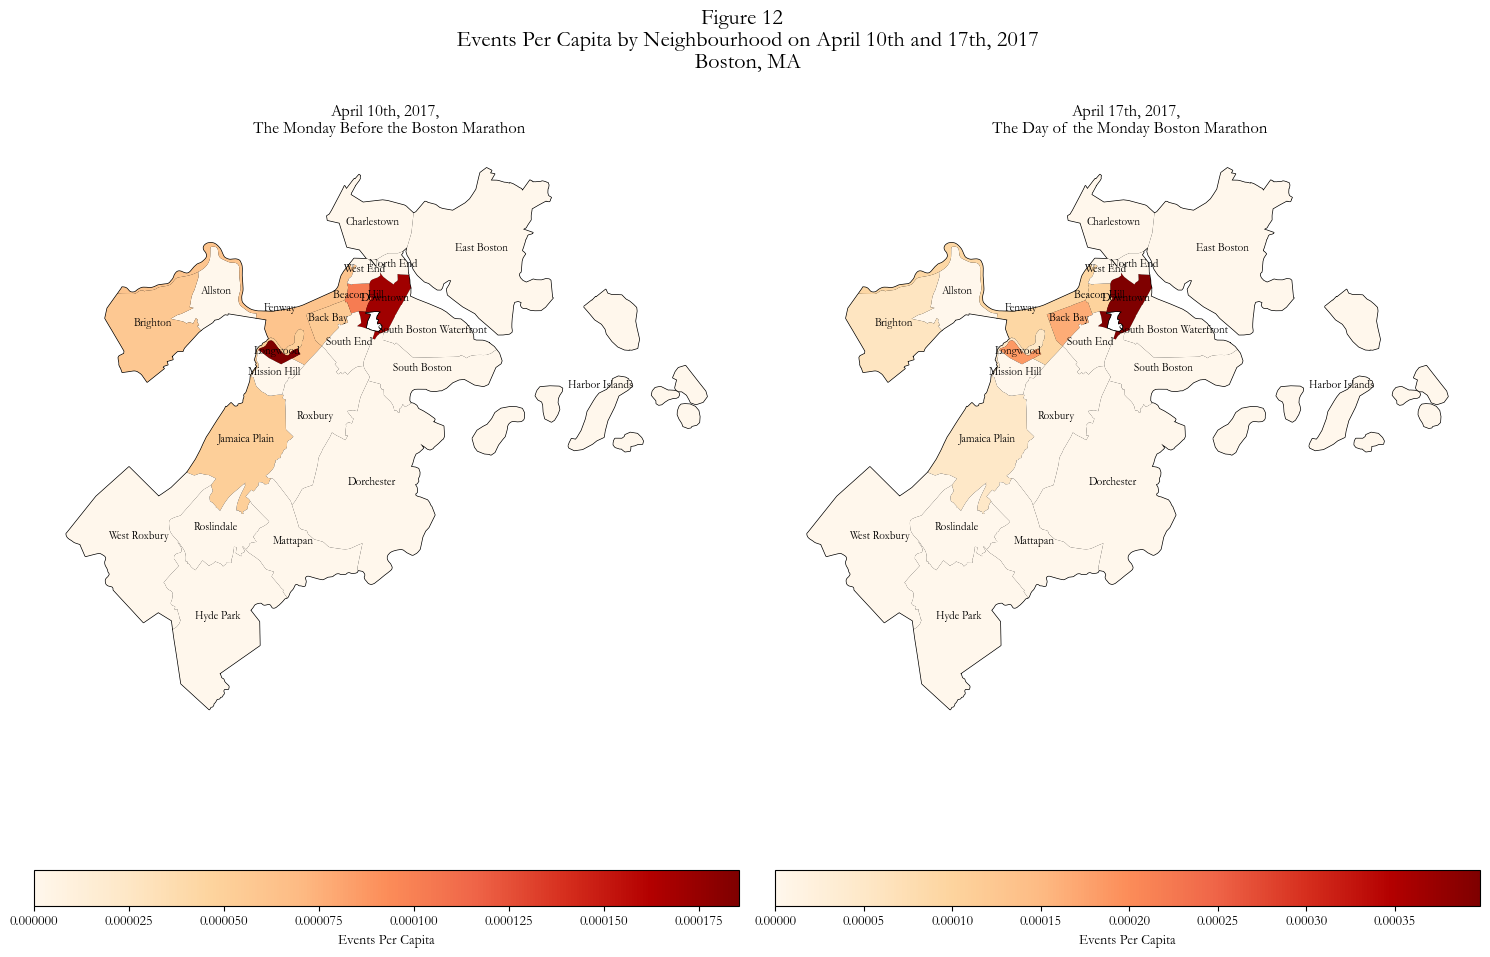

In [944]:
event_map_capita = event_map.copy()

#Create function to prepare event map
def prepare_event_map(df, date):
    #Filter for date
    df = df[df["Date"] == date]
    #Count number of events per neighbourhood
    grouped_event_map_capita = df.groupby(
        "neighborhood")["Event"].count().reset_index()
    #Rename columns
    grouped_event_map_capita.rename(columns={"Event": 
        "Event Count"}, inplace=True)
    #Merge count per neighbourhood with neighbourhoods geodataframe
    neighbourhoods_pop = boston_neighbourhoods.merge(
        grouped_event_map_capita, on="neighborhood", how="left")
    #Fill NaN values with 0
    neighbourhoods_pop["Event Count"] = neighbourhoods_pop[
        "Event Count"].fillna(0)
    #Add population column
    neighbourhoods_pop["population"] = neighbourhoods_pop[
        "neighborhood"].map(population_by_neighbourhood)
    #Drop NaN population values
    neighbourhoods_pop.dropna(subset=["population"], inplace=True)
    #Create events per capita column
    neighbourhoods_pop["Events Per Capita"] = neighbourhoods_pop[
    "Event Count"] / neighbourhoods_pop["population"]
    #Return dataframe 
    return neighbourhoods_pop

#Create mapping dataframes for April 10th and 17th with function above
neighbourhoods_10 = prepare_event_map(event_map_capita, "2017-04-10")
neighbourhoods_17 = prepare_event_map(event_map_capita, "2017-04-17")

#Configure figure and axes
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

#Plot neighbourhoods for ax[0]
boston_neighbourhoods.plot(ax=ax[0], color="white", edgecolor="black")
#Plot events per capita for April 10th  
neighbourhoods_10.plot(column="Events Per Capita", ax=ax[0], legend=True, 
                       cmap="OrRd",
                       legend_kwds={"label": 
                        "Events Per Capita", "orientation": "horizontal"})
#Create title
ax[0].set_title("April 10th, 2017, "
"\n The Monday Before the Boston Marathon")
#Remove axis
ax[0].set_axis_off()
#Label neighbourhoods
for idx, row in neighbourhoods_10.iterrows():
    ax[0].annotate(row["neighborhood"], row.geometry.centroid.coords[0], 
                   fontsize=8, ha="center")

#Plot neighbourhoods for ax[1]
boston_neighbourhoods.plot(ax=ax[1], color="white",
     edgecolor="black")
#Plot events per capita for April 17th
neighbourhoods_17.plot(column="Events Per Capita", ax=ax[1], legend=True, 
                       cmap="OrRd",
                       legend_kwds={"label": 
                        "Events Per Capita", "orientation": "horizontal"})
#Create title
ax[1].set_title("April 17th, 2017, "
"\n The Day of the Monday Boston Marathon")
#Remove axis
ax[1].set_axis_off()
#Label neighbourhoods
for idx, row in neighbourhoods_17.iterrows():
    ax[1].annotate(row["neighborhood"], row.geometry.centroid.coords[0], 
                   fontsize=8, ha="center")
    
fig.suptitle("Figure 12 \n Events Per Capita by Neighbourhood on April 10th and 17th, 2017"
"\n Boston, MA", y = 1.01, fontsize=16)

plt.tight_layout()

plt.show()

The purpose of this map is to see if there was a significant change in the number of events in "close" neighbourhoods between a day that is a week before the Boston Marathon, and the day of the marathon itself. If "close" neighbourhoods had relatively more events per capita on the day of the Boston Marathon, then it could be that these other events, and not just the marathon itself, are driving the Airbnb price surge, ultimately making my regression estimates of the marathon's price effect overstated.  

Based on the figure above, I do not notice any significant change in events per capita in "close" nieghbourhoods between the two periods. This map ultimately strengthens the claim that the Boston Marathon was the driver of the Airbnb price surge in "close" neighbourhoods.

## 8.4.2. Bar Graph of Event Count by Day by Event Type

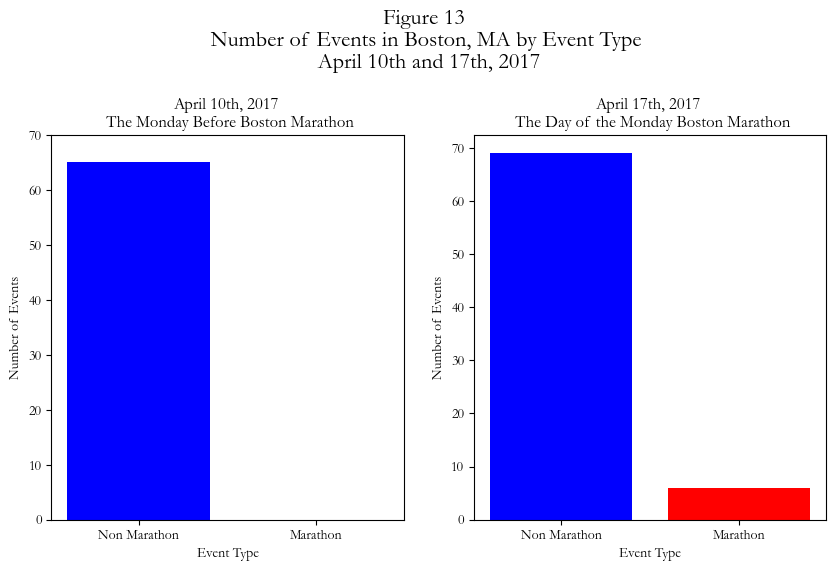

In [945]:
dates = ["2017-04-10", "2017-04-17"]

#Create empty list
count_day = []

#Loop through dates
for day in dates:
    #Filer for day
    filtered = event_location[event_location["Date"] == day]
    #Check if event name mentions marathon
    is_marathon = filtered["Event"].str.contains("marathon", case=False, na=False)
    #Count the occurrences of True and False and use reindex to ensure that
    #if any false or true are missing that it gets filled with 0
    count = is_marathon.value_counts().reindex([False, True], fill_value=0)
    #Append the count to the list
    count_day.append(count)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#Create bar plot for April 10th
ax[0].bar(["Non Marathon", "Marathon"], 
          count_day[0], color=["blue", "red"])

ax[0].set_title("April 10th, 2017 \n "
"The Monday Before Boston Marathon")
ax[0].set_ylabel("Number of Events")
ax[0].set_yticks(range(0, 80, 10))
ax[0].set_xlabel("Event Type")

#Create bar plot for April 17th
ax[1].bar(["Non Marathon", "Marathon"], 
          count_day[1], color=["blue", "red"])

ax[1].set_title("April 17th, 2017 \n "
"The Day of the Monday Boston Marathon")
ax[1].set_ylabel("Number of Events")
ax[1].set_yticks(range(0, 80, 10))
ax[1].set_xlabel("Event Type")

fig.suptitle("Figure 13 \n Number of Events in Boston, MA by Event Type \n"
" April 10th and 17th, 2017", fontsize=16, y=1.13)



plt.show()



The above figure displays the counts for the number of events in Boston by day and event type. 

While there was a slight increase in the number of non-marathon related events on April 17th, there were also close to 10 marathon related events on this day as well. I assume that these marathon related events are held in locations close to the marathon itself. From this, any increase in events per capita in "close" neighbourhoods could reasonably be attributed to these additional marathon related events. Thus, I can reasonably claim that the Airbnb price increase was caused by the Boston Marathon itself, or marathon related events, rather than non-marathon events occurring in the "close" neighbourhoods on the day of the Boston Marathon.

# 9. Machine Learning

## 9.1. The Objective Function

$$
\min_{j, s} \left[\sum_{i : x_{i,j} \leq s,\ x_i \in R} \left( \log(\text{Price}_{i}) - \widehat{\log(\text{Price})}_{R_1} \right)^2 + \sum_{i : x_{i,j} > s,\ x_i \in R} \left( \log(\text{Price}_{i}) - \widehat{\log(\text{Price})}_{R_2} \right)^2\right]
$$

This is the function used to generate each node in the regression tree.

The selected node is chosen like this: Over all covariates a threshold is defined. Then, on each side of the threshold the average value of log(Price) is calculated. From this, the sum of squared residuals is calculated based on the distance between the average and each observed price and is then stored. After, another threshold is set and this process repeats. Once all the sums of squared errors are calculated for each threshold over each covariate, the threshold for the covariate that yields the lowest error is selected as the first node in the regression tree.

My interpretation was inspired by: https://www.youtube.com/watch?v=g9c66TUylZ4&t=1166s.

Note: The above formula was adapted from the formula in the Machine Learning PDF provided by the professor in Week 12 Slides and Notebook.

## 9.2. Regularization Paramaters

Regularization parameters include:

- max_dpth: This parameter determines the total number of 'levels' in a regression tree. Increasing max_dpth then means extending the regression tree to include more nodes, which will increasingly subset the data to create more accurate predictions and reduce the sum of squared residuals. Of course, increasing max_depth can lead to overfitting, which may reduce the external validity of the regression tree, meaning it harder to apply to other contexts or samples.

- min_samples_leaf: If on one side of a threshold there are fewer than a defined number of observations, then the node will become a 'leaf' and will no longer be split on.

## 9.3. Regression Tree With Difference-In-Differences Covariates

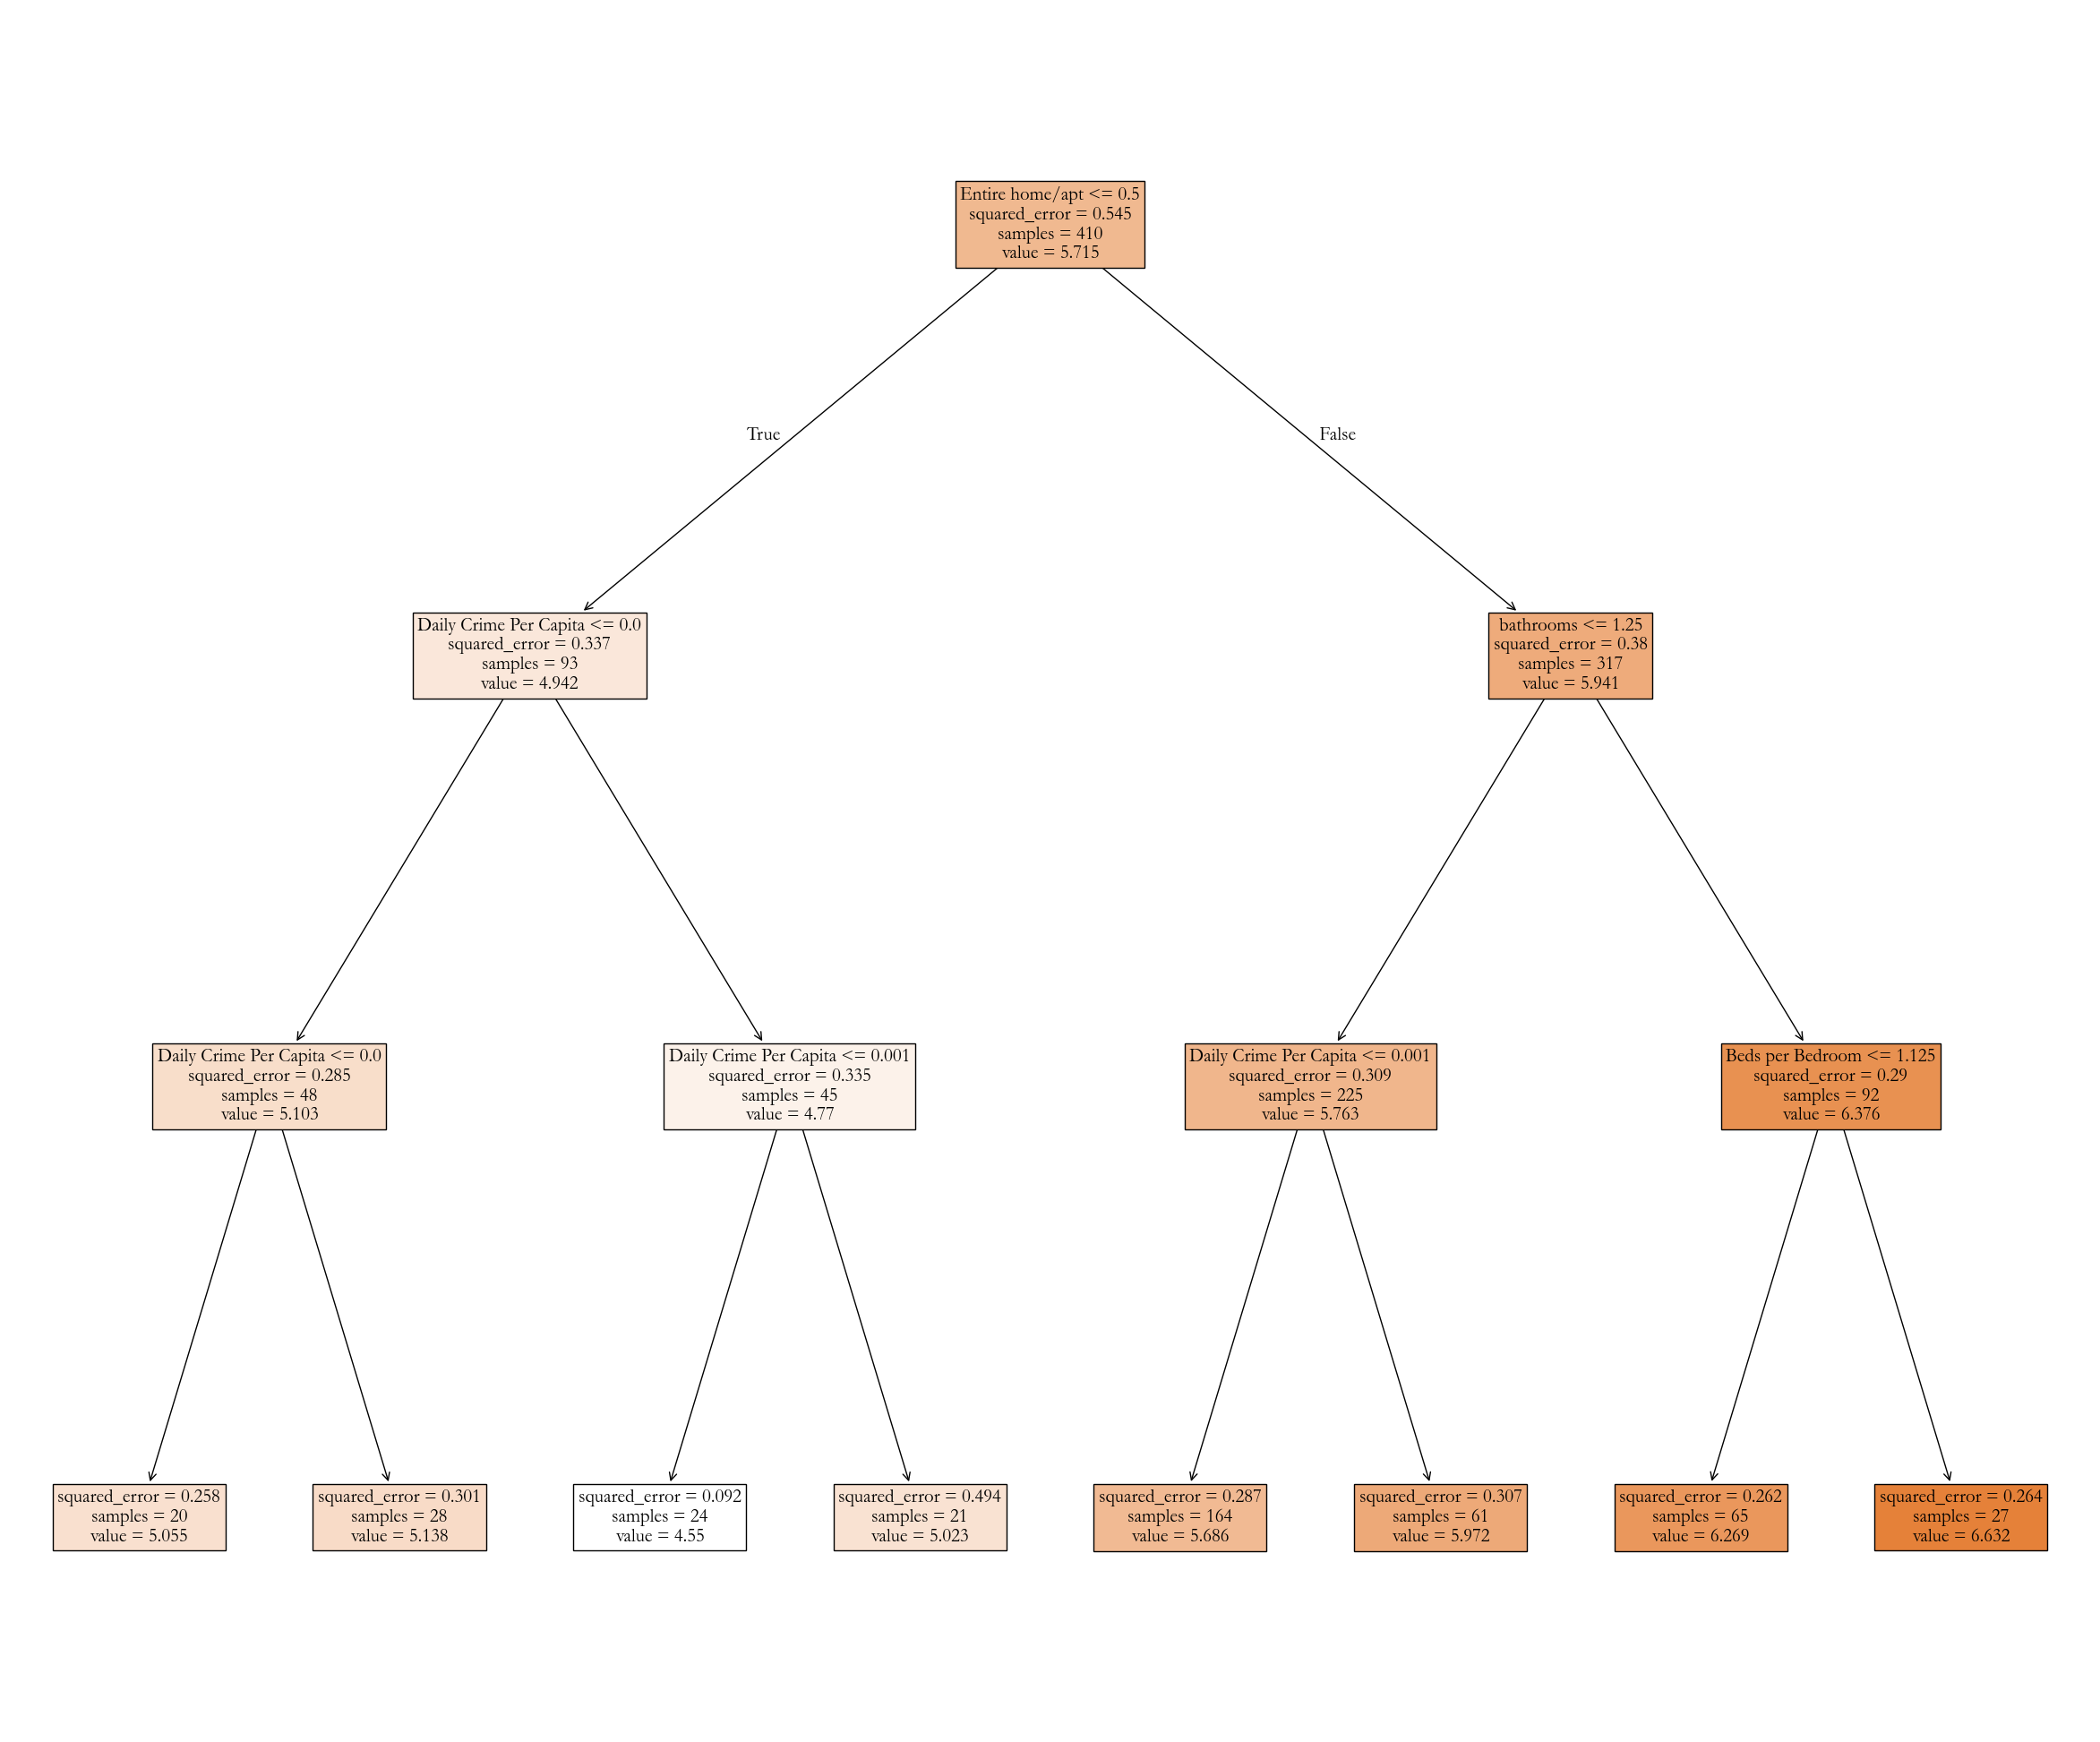

In [946]:
from sklearn import tree
from sklearn import metrics

ml_frame1 = reg_frame1.copy()

#Filter the data to only include marathon day and treatment listings
tree_data = ml_frame1[(ml_frame1["Marathon Period"] == 1) & \
                      (ml_frame1["treatment"] == 1)].copy()

#Define Y variable
Y = tree_data["Log(Price)"]

#Define X variables
X = tree_data[["Superhost",
        "Beds per Bedroom", "bathrooms", 
        "Daily Crime Per Capita",
        'Entire home/apt', 'Private room', 'Shared room',
       'Apartment', 'Bed & Breakfast', 'Boat', 'Camper/RV', 
       'Condominium',
       'Dorm', 'Entire Floor', 'Guesthouse', 'House', 'Loft', 
       'Other',
       'Townhouse', 'Villa']]

#Create a fitted decision tree
tree_var = tree.DecisionTreeRegressor(max_depth=3, 
    min_samples_leaf=20).fit(X, Y)
#Use the fitted tree to predict Y
y_pred_tree = tree_var.predict(X)

#Configure figure
sqrf_fig = plt.figure(figsize=(30,25))

#Plot the decision tree
sqrf_fig = tree.plot_tree(tree_var, feature_names=X.columns, 
    filled=True, fontsize=15)

plt.show()

I am using my regression tree above to predict which characteristics of treated Airbnb’s on the day of the Boston Marathon yielded the highest listing price. 

The X variables I include are directly from my first Difference-in-differences regression model.

Based on the regression tree above, entire homes or apartments with more than 1.25 bathrooms and more than 1.125 beds per bedroom yielded the highest listing price among treated listings on the day of the Boston Marathon, on average. This ultimately suggests that larger, private listings captured the highest prices on marathon day.



## 9.4. Regression Tree With Extra Covariates

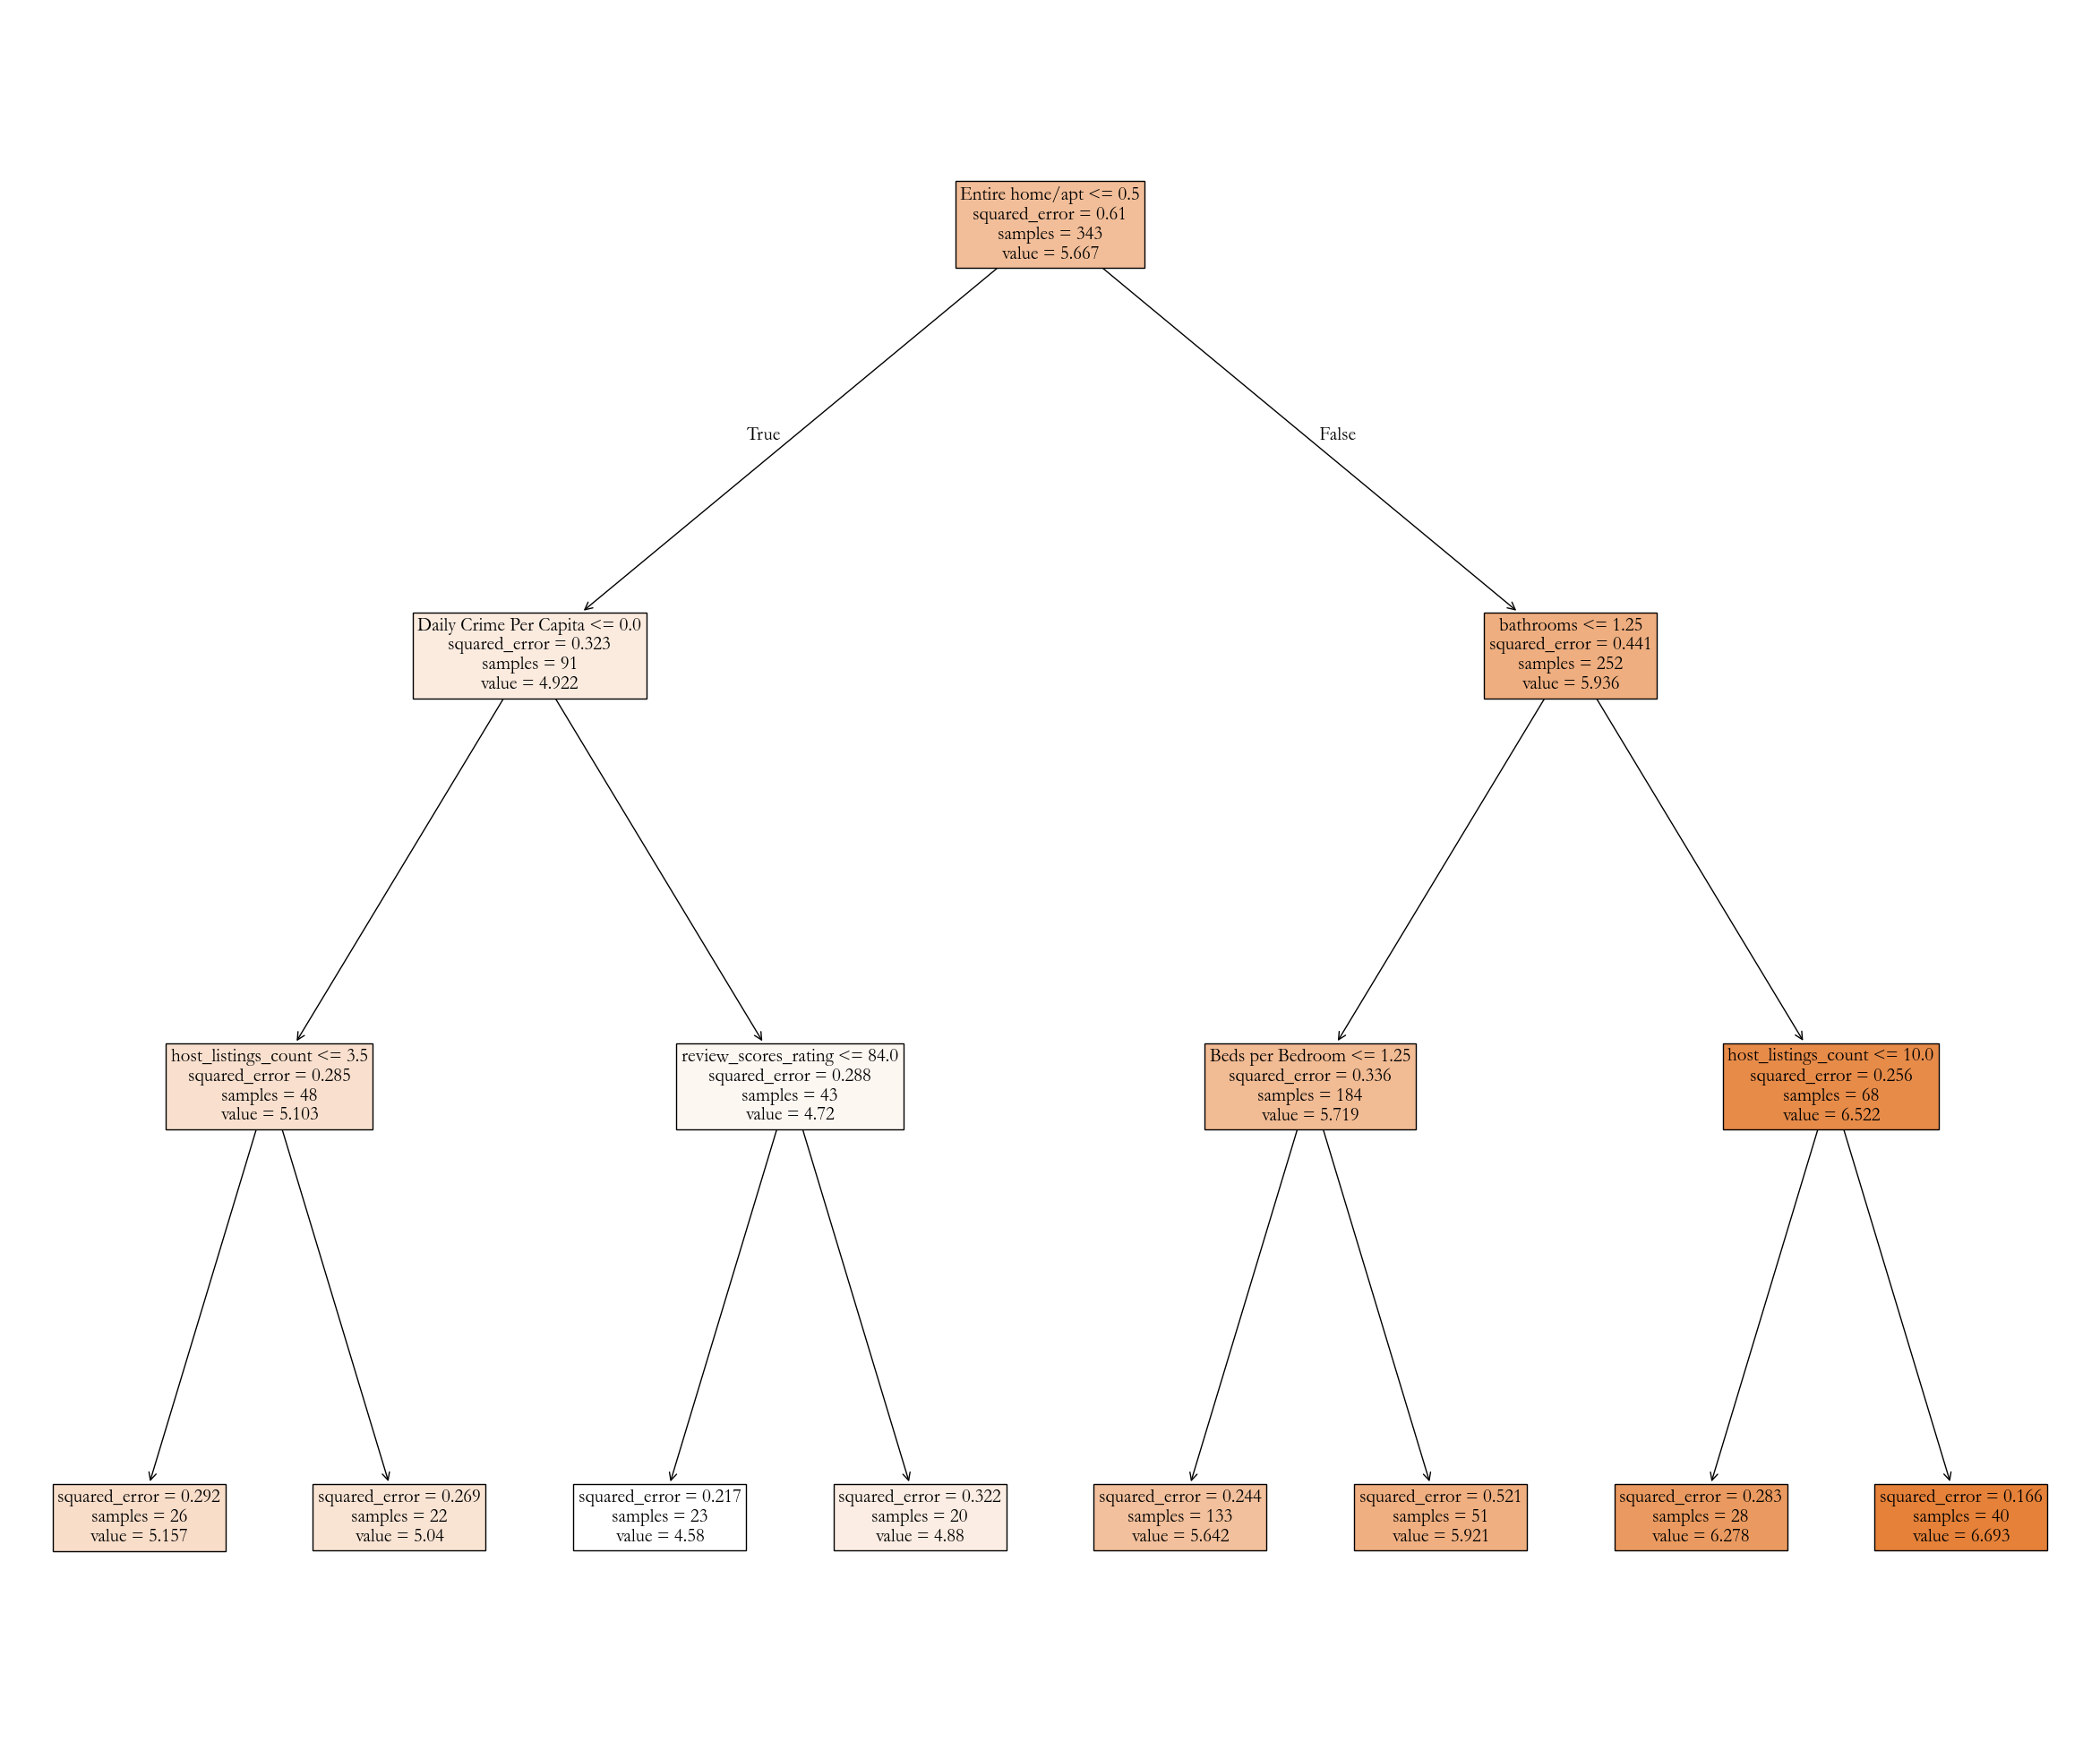

In [947]:
ml_frame2 = reg_frame1.copy()

#Remove outliers
cutoff = reg_frame1["host_listings_count"].quantile(0.95)
ml_frame2 = reg_frame1[reg_frame1["host_listings_count"] <= cutoff].copy()

#Filter the data to only include marathon day and treatment listings
tree_data2 = ml_frame2[(ml_frame2["Marathon Period"] == 1) & \
                      (ml_frame2["treatment"] == 1)].copy()

#Define Y variable
Y = tree_data2["Log(Price)"]

#Define X variables
X2 = tree_data2[[
       'host_listings_count', 'bathrooms', 'review_scores_rating',
       'Superhost', 'Entire home/apt', 'Private room', 'Shared room',
       'Apartment', 'Bed & Breakfast', 'Boat', 'Camper/RV', 'Condominium',
       'Dorm', 'Entire Floor', 'Guesthouse', 'House', 'Loft', 'Other',
       'Townhouse', 'Villa', 'Airbed', 'Couch', 'Futon', 'Pull-out Sofa',
       'Real Bed', 'Beds per Bedroom', 'Daily Crime Per Capita']]

#Create a fitted decision tree
tree_var2 = tree.DecisionTreeRegressor(max_depth=3, 
       min_samples_leaf=20).fit(X2, Y)
#Use the fitted tree to predict Y
y_pred_tree2 = tree_var2.predict(X2)

#Configure figure
sqrf_fig2 = plt.figure(figsize=(30,25))

#Plot the decision tree
sqrf_fig2 = tree.plot_tree(tree_var2, feature_names=X2.columns, 
       filled=True, fontsize=15)

plt.show()

Above, I run another regression tree with additional covariates: bed type, review score rating, and host listings count.

The regression tree above shows that, on average, among treated Airbnb's on the day of the Boston Marathon, those that are entire homes or apartments, have more than 1.25 bathrooms, and were listed by hosts with more than 10 properties yielded the highest price. This ultimately suggests that career hosts benefited the most in terms of the absolute price level. Importantly, this node also has the lowest squared error of 0.166. I could add another layer of depth to the tree to decrease this even more. However, I do not want to overfit my model and reduce its external validity.

Comparing this tree to my first, both trees initially split on Entire home/apt and then split again on Daily Crimes per Capita and bathrooms. Beyond this, however, host listings count and review score rating are then split on in my second tree, meaning these covariates are more influential relative to other thresholds for Daily Crimes per Capita, which are again split on in the third layer in the first tree.

## 9.5. Random Forest

In [948]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#Select 5 variables randomly
regr_RF = RandomForestRegressor(max_features=5, random_state=1).fit(X2, Y)
pred = regr_RF.predict(X2)
mean_squared_error(Y, pred)

0.05688450269854888

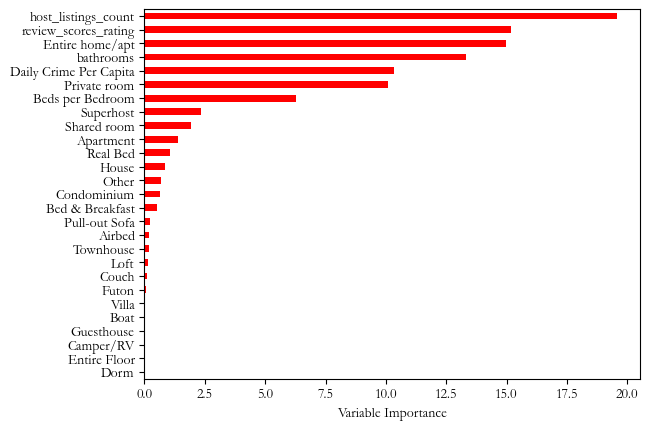

In [949]:
Importance = pd.DataFrame({'Importance':regr_RF.feature_importances_*100}, 
    index=X2.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(
    kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

The importance matrix ranks each covariate based on how much it reduces the mean squared error when we split the data on that covariate. The larger the reduction, the more important the covariate. Based on the matrix above, the indicator for Entire home or apartment is the most important variable in the regression tree. This means that splitting the data on Entire home or apartment leads to the largest reduction in the mean squared error relative to the other covariates.

## 9.6. OLS vs ML

My Difference-in-Differences regressions estimate the average change in Airbnb listing price caused by the Boston Marathon. Notably, the DiD regressions utilized a panel dataset. In contrast, my machine learning models are used for the prediction of prices based on covariates among treated listings on only the day of the Boston Marathon. Thus, the ML model does not capture the change in price brought about by the marathon, but rather which types of treated listings had the highest prices on marathon day. 

This leads to a discussion of identifying who benefits most from the marathon. Of course, it is possible that certain listings had a larger price increase brought about by the marathon, even if their price was lower overall on marathon day compared to listings described in the regression tree. One could argue that these people benefited the most from the marathon rather than people who had the highest absolute price on marathon day.

# 10. Conclusion

To conclude, I examine the effect of the Boston Marathon on the Boston Airbnb market. I do this by finding that the effect of the marathon on listing price is isolated to only Airbnb’s that are ‘close’ to the Boston Marathon finish line. From this, I conduct a difference-in-differences regression analysis that assigns listings into treatment and control groups based on their distance to said finish line. I find that there was a ‘Boston Marathon effect’ on Airbnb listing prices, as prices increased significantly in response to the marathon. My results also suggest that Superhosts vary in their 'marathon pricing strategy' compared to non Superhosts, as Superhosts increased their prices in response to the marathon by a significantly higher amount. In addition to this, I have determined that entire homes or apartments with more than 1 bathroom that are managed by a host with more than 10 properties had the highest price listing price on the day of the Boston Marathon, on average.

More work needs to be done to measure how supply changes over time in response to the Boston Marathon. Unfortunately, my dataset does not allow me to assess this because my data was obtained by scraping Airbnb on a single day. Prices, however, can be set far in advance, which is why I could measure a marathon price effect. 


# Bibliography

Analyze Boston & Boston Planning & Development Agency. (2018). *Demographic Data for Boston’s Neighborhoods, 1950-2019*. [Data Set]. https://data.boston.gov/dataset/neighborhood-demographics.

AnkurJain. (2019). *Crimes in Boston*. [Data Set]. https://www.kaggle.com/datasets/ankkur13/boston-crime-data.

Angrist, J. D., & Pischke, J.-S. (2015). *Mastering ’Metrics: The Path From Cause to Effect*. Princeton University Press.

Benítez-Aurioles, B., & Tussyadiah, I. (2021). What Airbnb does to the housing market. *Annals of Tourism Research*, 90, 103108-. https://doi.org/10.1016/j.annals.2020.103108.

Boston Athletic Association Communications Department. (2017, March 23). *2017 Boston Marathon Will Mean $192.2 Million For Greater Boston Economy*. Boston Athletic Association. https://www.baa.org/2017-boston-marathon-will-mean-1922-million-greater-boston-economy.

Brady, J. (2017, April 17). *Boston Marathon 2017: Route information, course map, road closures and more*. SB Nation. https://www.sbnation.com/2017/4/17/15284838/2017-boston-marathon-route-map-traffic.

Brunstein, D., Casamatta, G., & Giannoni, S. (2025). Using machine learning to estimate the heterogeneous impact of Airbnb on house prices: Evidence from Corsica. *Journal of Housing Economics*, 67, 102044-. https://doi.org/10.1016/j.jhe.2025.102044.

Cachon, G. P., Daniels, K. M., & Lobel, R. (2017). The Role of Surge Pricing on a Service Platform with Self-Scheduling Capacity. *Manufacturing & Service Operations Management*, 19(3), 368–384. https://doi.org/10.1287/msom.2017.0618.

Cheung, K. S., & Yiu, C. Y. (2023). The paradox of airbnb, crime and house prices: A reconciliation. *Tourism Economics: The Business and Finance of Tourism and Recreation*, 29(5), 1412–1418. https://doi.org/10.1177/13548166221102808.

City of Boston. (2009). *Neighbourhoods*. City of Boston. https://www.cityofboston.gov/images_documents/Neighborhoods_tcm3-8205.pdf. 

Cunningham, S. (2021). *Causal Inference: The Mixtape*. Yale University Press.

Ert, E., & Fleischer, A. (2019). The evolution of trust in Airbnb: A case of home rental. *Annals of Tourism Research*, 75, 279–287. https://doi.org/10.1016/j.annals.2019.01.004.

Fredriksson, A., & Oliveira, G. M. de. (2019). Impact evaluation using Difference-in-Differences. *RAUSP Management Journal*, 54(4), 519–532. https://doi.org/10.1108/RAUSP-05-2019-0112.

Gultekin, H. (2023, August 9). *Convert Address to Latitude Longitude using Python.* Medium. https://medium.com/@hazallgultekin/convert-address-to-latitude-longitude-using-python-21844da3d032.

Jiao, J. (2018). Investigating Uber price surges during a special event in Austin, TX. *Research in Transportation Business & Management*, 29, 101–107. https://doi.org/10.1016/j.rtbm.2018.02.008.

Jiménez, J. L., Ortuño, A., & Pérez-Rodríguez, J. V. (2022). How does AirBnb affect local Spanish tourism markets? *Empirical Economics*, 62(5), 2515–2545. https://doi.org/10.1007/s00181-021-02107-2.

Kadi, J., Plank, L., & Seidl, R. (2022). Airbnb as a tool for inclusive tourism? *Tourism Geographies*, 24(4–5), 669–691. https://doi.org/10.1080/14616688.2019.1654541.

Lawani, A., Reed, M. R., Mark, T., & Zheng, Y. (2019). Reviews and price on online platforms: Evidence from sentiment analysis of Airbnb reviews in Boston. *Regional Science and Urban Economics*, 75, 22–34. https://doi.org/10.1016/j.regsciurbeco.2018.11.003.

Leoni, V., & Nilsson, W. (2021). Dynamic pricing and revenues of Airbnb listings: Estimating heterogeneous causal effects. *International Journal of Hospitality Management*, 95, 102914-. https://doi.org/10.1016/j.ijhm.2021.102914.

Liang, C., Yeung, M. C. H., & Au, A. K. M. (2022). The impact of Airbnb on housing affordability: Evidence from Hong Kong. *Environment and Planning. B, Urban Analytics and City Science*, 49(3), 1048–1066. https://doi.org/10.1177/23998083211043123.

Lorde, T., Jacob, J., & Weekes, Q. (2019). Price-setting behavior in a tourism sharing economy accommodation market: A hedonic price analysis of AirBnB hosts in the caribbean. *Tourism Management Perspectives*, 30, 251–261. https://doi.org/10.1016/j.tmp.2019.03.006.

Piga, C., & Melis, G. (2021). Identifying and measuring the impact of cultural events on hotels’ performance. *International Journal of Contemporary Hospitality Management*, 33(4), 1194–1209. https://doi.org/10.1108/IJCHM-07-2020-0749.

Segu, M., Garcia-López, M.-À., Jofre-Monseny, J., & Martínez-Mazza, R. (2020). Do short-term rental platforms affect housing markets? Evidence from Airbnb in Barcelona. *Journal of Urban Economics*, 119, 103278-. https://doi.org/10.1016/j.jue.2020.103278.

Wolak, A., & Airbnb. (2020). *Boston Airbnb Open Data*. [Data Set]. https://www.kaggle.com/datasets/airbnb/boston. 